## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
def camera_cali():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img) # this will a window showing the images with corners drawed
            #cv2.waitKey(100)

    #cv2.destroyAllWindows()
    return objpoints, imgpoints

objpoints, imgpoints = camera_cali()

## Apply the camera calibration given objpoints and image points

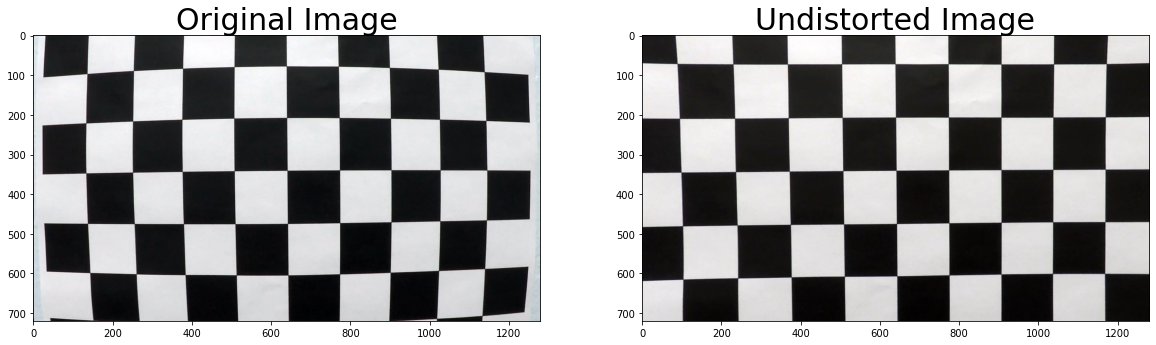

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')

def undistort(img,objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('../output_images/camera_cal_out.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "../output_images/wide_dist_pickle.p", "wb" ) )
    return img,dst

img,dst = undistort(img,objpoints, imgpoints)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('image1.jpg')


In [3]:
## Use color transforms, gradients, etc., to create a thresholded binary image.

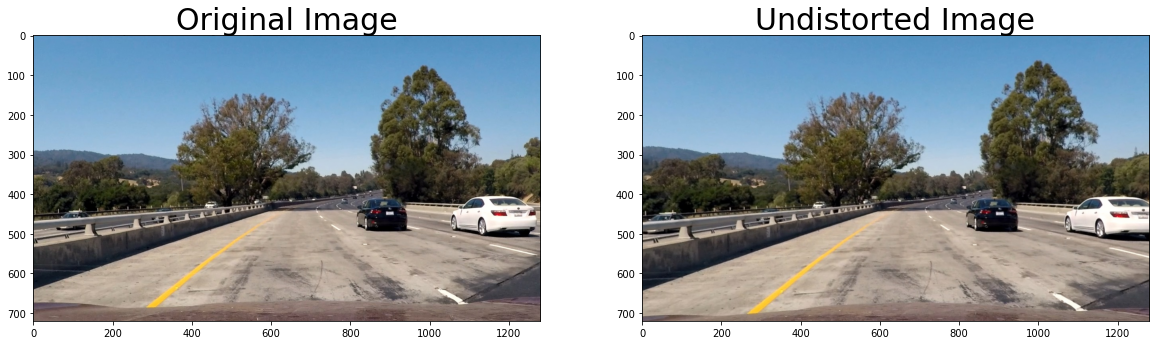

In [4]:


img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../output_images/test1_out.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "../output_images/test1_wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('image2.jpg')


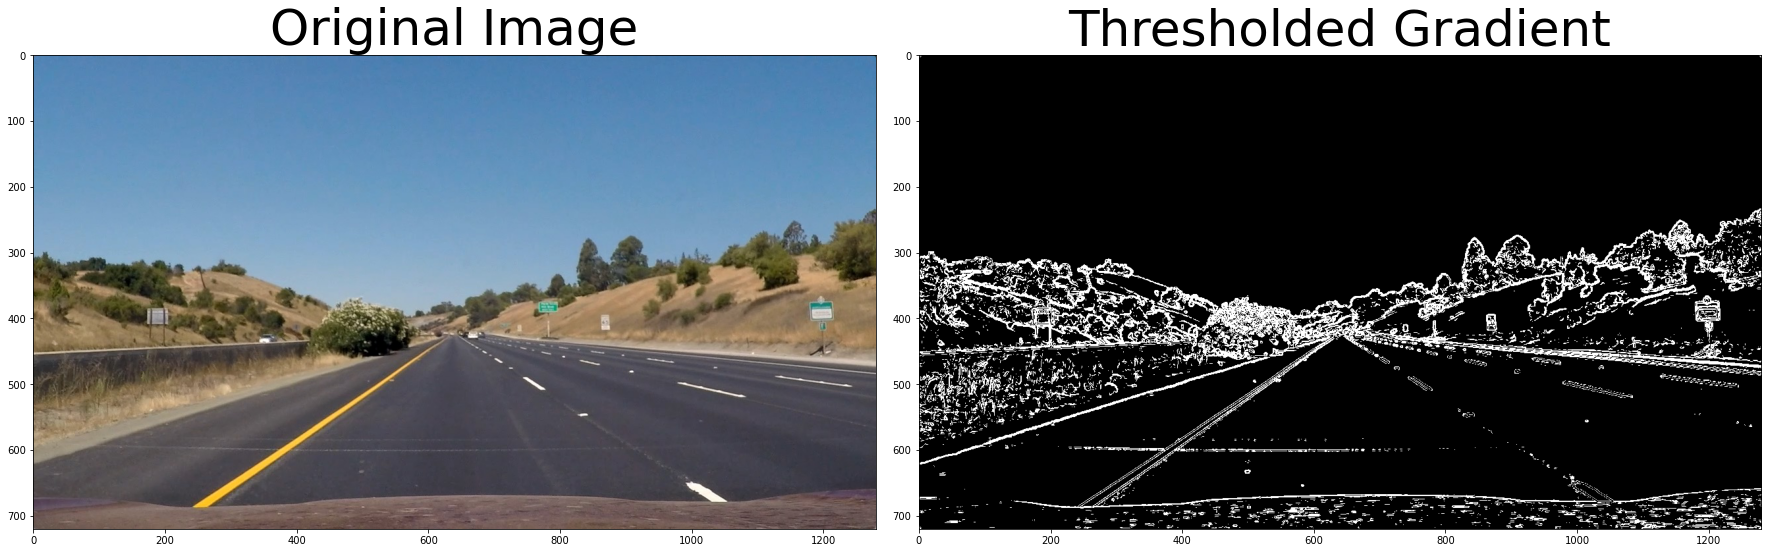

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle



# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Read in an image and grayscale it
image = mpimg.imread('../test_images/straight_lines1.jpg')
ksize = 3
# Run the function
grad_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(20,100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('image3.jpg')



In [6]:
# Choose a Sobel kernel size

def thresh_image(image,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200)):
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=threshx)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=threshy)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=thresh_mag)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return image,mag_binary


"""
image,mag_binary = thresh_image(img,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""


"\nimage,mag_binary = thresh_image(img,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200))\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(mag_binary, cmap='gray')\nax2.set_title('Thresholded Gradient', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

In [7]:
## Perspective Transformation


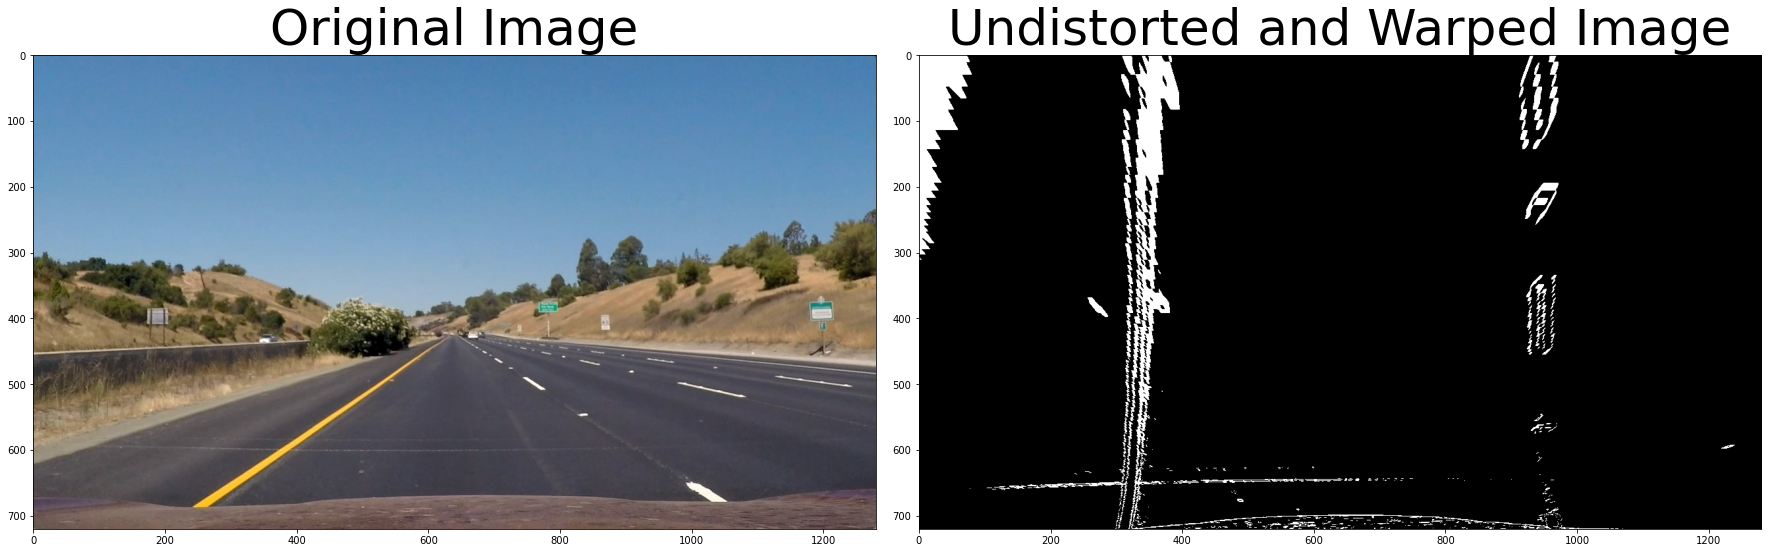

In [8]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    # gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    gray = img
    # Search for corners in the grayscaled image
    #ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    ret = 1

    if ret == True:
        
        # If we found corners, draw them! (just for fun)
        # cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        """
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
                                     
        """
        
        src = np.float32(
            [[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 20), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        
        #print("src=\n",src)
        
        #print("dst=\n",dst)
        
      
        
        """
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
            
        """
        

        
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        # print("M is",M)
        # Warp the image using OpenCV warpPerspective()
        
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv




# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load(open( "./wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
#print("mtx,dist",mtx,dist)

# Read in an image
# img = cv2.imread('../test_images/test_image2.png')
# img = cv2.imread('../test_images/straight_lines1.jpg')


top_down, perspective_M, Minv = corners_unwarp(grad_binary, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('image4.jpg')

In [9]:


## locate the lane lines

In [10]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
# img = mpimg.imread('warped_example.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = None
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = None
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
# histogram = hist(top_down)

# Visualize the resulting histogram
# plt.plot(histogram)

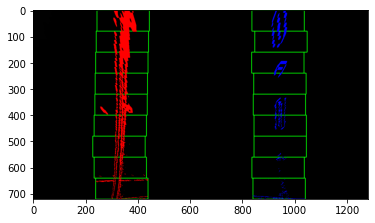

In [11]:

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
# binary_warped = mpimg.imread('warped_example.jpg')
# binary_warped = top_down
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img,ploty,left_fitx, right_fitx,left_fit, right_fit


out_img,ploty,left_fitx, right_fitx,left_fit, right_fit = fit_polynomial(top_down)

plt.imshow(out_img)
plt.savefig('image5.jpg')

In [12]:
# calculate the curvature


In [13]:
def measure_curvature_pixels(ploty,left_fit, right_fit, ym_per_pix=30/720, xm_per_pix=3.7/700):
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    
   

    y_eval = np.max(ploty)*ym_per_pix
    print("y_eval is",y_eval)
    #print("left_fit\n",left_fit)
    #print("right_fit\n",right_fit)
    # print("the car position respect to center of the two line is",(left_fit[0]+right_fit[1])/2 - binary_warped.shape[1]/2)
    left_a_new = xm_per_pix/(ym_per_pix**2)*left_fit[0]
    left_b_new = xm_per_pix/(ym_per_pix)*left_fit[1]
    right_a_new = xm_per_pix/(ym_per_pix**2)*right_fit[0]
    right_b_new = xm_per_pix/(ym_per_pix)*right_fit[1]
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_a_new*y_eval + left_b_new)**2)**1.5) / np.absolute(2*left_a_new)
    right_curverad = ((1 + (2*right_a_new*y_eval + right_b_new)**2)**1.5) / np.absolute(2*right_a_new)
    
    return left_curverad, right_curverad
    
def measure_offset(img,left_fitx, right_fitx,ym_per_pix=30/720, xm_per_pix=3.7/700):
    if (len(right_fitx)>0 and len(left_fitx)>0):
        pix_off = (right_fitx[0] - left_fitx[0])/2 - img.shape[1]/2
        dis_off = pix_off *  xm_per_pix
    else:
        dis_off = 0
        
    return dis_off
    
    

In [14]:
# Define conversions in x and y from pixels space to meters
#ym_per_pix = 30/720 # meters per pixel in y dimension
#xm_per_pix = 3.7/700 # meters per pixel in x dimension
#left_curverad, right_curverad = measure_curvature_pixels(ploty,left_fitx, right_fitx, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix)

#print(left_curverad, right_curverad)

In [15]:
def add_curve_on_pic(image, left_curverad, right_curverad, offset, color=(255,0,0)):
    direction = "right" if offset < 0 else "left"
    str_cur = "curverad = {}(m)".format(int((left_curverad + right_curverad)/2))
    str_offset = "Car is {0:.2f}m ".format(abs(offset)) + "{} away off center".format(direction)
    cv2.putText(image, str_cur, (50,60), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    cv2.putText(image, str_offset, (50,120), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    
    
    

In [16]:


# transform back to real world curvature

In [17]:
## plot area between the lane back to the image

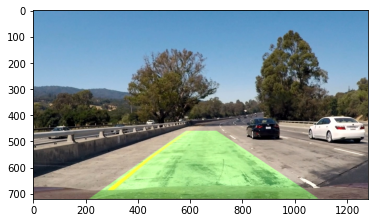

In [18]:
def draw_lane_fit(undist, warped ,Minv, left_fitx, right_fitx, ploty):
    # Drawing
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix(Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    #print("newwarp",newwarp.shape[0],newwarp.shape[1],newwarp.shape[2])
    #print("undist",undist.shape[0],undist.shape[1],newwarp.shape[2])
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

#exampleImg_out1 = project_fit_lane_info(img, binary_warped, left_fitx, right_fitx, Minv)
#plt.imshow(exampleImg_out1)
#left_fitx, right_fitx
# print("Minv=\n",Minv)
result = draw_lane_fit(img,top_down,Minv,left_fitx, right_fitx, ploty)
plt.imshow(result)
plt.savefig('image6.jpg')

In [19]:
def pipeline(img):
    objpoints, imgpoints = camera_cali() # calibrate the camera 
       
    img,dst = undistort(img,objpoints, imgpoints) # apply the calibration on img
        
    img,mag_binary = thresh_image(img,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200))
    # img is the original image, mag_binary is the magnitude of x_derivative and y_derivative
    
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load(open("./wide_dist_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    top_down, perspective_M, Minv = corners_unwarp(mag_binary, mtx, dist)

    out_img,ploty,left_fitx, right_fitx ,left_fit, right_fit = fit_polynomial(top_down)
    
    left_curverad, right_curverad = measure_curvature_pixels(ploty,left_fit, right_fit)
    
    print("left_curverad, right_curverad",left_curverad, right_curverad)
    offset = measure_offset(img,left_fitx, right_fitx)
    print("offset is",offset)
    add_curve_on_pic(img, left_curverad, right_curverad, offset, color=(0,255,255))
    
    result = draw_lane_fit(img,top_down,Minv,left_fitx, right_fitx, ploty)
    
    #plt.imshow(result)
    
    #plt.savefig('image_pitfall.jpg')
    
    return result

img.shape[0] 720
y_eval is 29.958333333333332
left_curverad, right_curverad 422.0072015638149 679.4398880083253
offset is -0.8387643964024303


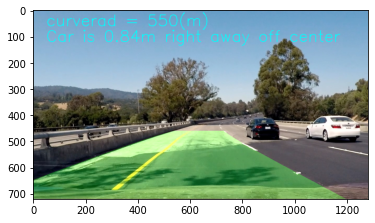

In [20]:
#img = cv2.imread('../camera_cal/calibration1.jpg')
img = mpimg.imread('../test_images/test4.jpg')
print("img.shape[0]",img.shape[0])

result = pipeline(img)
plt.imshow(result)
plt.savefig('image_pitfall.jpg')

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [22]:
def process_image(image):
    return pipeline(image)

In [23]:
white_output = '../project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,1)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 672.6066442403454 777.3201696702538
offset is -1.761835898289565
Moviepy - Building video ../project_video_out.mp4.
Moviepy - Writing video ../project_video_out.mp4



t:   0%|          | 2/1260 [00:02<22:59,  1.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 672.6066442403454 777.3201696702538
offset is -1.761835898289565


t:   0%|          | 3/1260 [00:04<33:01,  1.58s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 595.082186368858 957.4195246823749
offset is -1.7699322852894719


t:   0%|          | 4/1260 [00:06<37:50,  1.81s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 574.6528591209357 618.4835720645248
offset is -1.823247710976917


t:   0%|          | 5/1260 [00:08<41:24,  1.98s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 552.3645697300232 684.0846073599207
offset is -1.8331602037498151


t:   0%|          | 6/1260 [00:11<42:39,  2.04s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 659.8105051551365 788.3700216366191
offset is -1.8287201096493095


t:   1%|          | 7/1260 [00:13<43:24,  2.08s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 627.8994209278411 851.82028075356
offset is -1.8261588464140137


t:   1%|          | 8/1260 [00:15<44:07,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 711.6873018769473 804.0898390462844
offset is -1.8121700598227788


t:   1%|          | 9/1260 [00:17<44:32,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 754.6489752482157 696.5276095628518
offset is -1.823149346259666


t:   1%|          | 10/1260 [00:19<44:30,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 726.5607221125778 710.8639628295499
offset is -1.7975010770611501


t:   1%|          | 11/1260 [00:22<45:08,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 733.2971448432248 630.402392959149
offset is -1.802344258172166


t:   1%|          | 12/1260 [00:24<45:39,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 802.5993661653821 593.4396815546464
offset is -1.8346263061266468


t:   1%|          | 13/1260 [00:26<46:03,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 780.004050745217 706.8492349448012
offset is -1.7618575568706651


t:   1%|          | 14/1260 [00:28<45:58,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 874.6181396844664 925.51280172535
offset is -1.7677885490317984


t:   1%|          | 15/1260 [00:30<45:55,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 834.7868428630319 1302.1003134552593
offset is -1.758610728263926


t:   1%|▏         | 16/1260 [00:33<46:12,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 838.4383037779761 694.9282030622649
offset is -1.8537737592455352


t:   1%|▏         | 17/1260 [00:35<46:24,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 793.9093567914549 823.6998723884624
offset is -1.8849435987914476


t:   1%|▏         | 18/1260 [00:37<46:33,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 939.6903984003383 1065.3560683076273
offset is -1.880452665808982


t:   2%|▏         | 19/1260 [00:39<46:23,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 882.8332454865946 904.769307706591
offset is -1.8879407975095888


t:   2%|▏         | 20/1260 [00:42<46:13,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1022.1345807436759 987.3833239168112
offset is -1.8595372813318733


t:   2%|▏         | 21/1260 [00:44<46:22,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1086.560763526457 749.6942026835102
offset is -1.8379913101705807


t:   2%|▏         | 22/1260 [00:46<46:22,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1135.1245486194143 651.7377645042837
offset is -1.8038494746147544


t:   2%|▏         | 23/1260 [00:48<46:10,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1130.5515520029999 656.1305913642468
offset is -1.7734768571611594


t:   2%|▏         | 24/1260 [00:51<45:57,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1097.365752799732 742.3541509782357
offset is -1.7464584375677596


t:   2%|▏         | 25/1260 [00:53<45:39,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1064.5053970501199 625.5056265169598
offset is -1.785174938022027


t:   2%|▏         | 26/1260 [00:55<45:26,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 916.2325854782796 785.7149751223602
offset is -1.7931523285414064


t:   2%|▏         | 27/1260 [00:57<45:47,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 885.5029010500149 692.2478592511245
offset is -1.7573598740922345


t:   2%|▏         | 28/1260 [01:00<45:48,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 856.7609045857558 1054.085250657852
offset is -1.7374390662839845


t:   2%|▏         | 29/1260 [01:02<45:54,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 791.7560211151514 1487.2877753429116
offset is -1.676256272046538


t:   2%|▏         | 30/1260 [01:04<45:55,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 732.8089996193933 988.0230239277115
offset is -1.725850265349676


t:   2%|▏         | 31/1260 [01:06<45:28,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 730.2822337137071 696.9880974771457
offset is -1.7908053797146355


t:   3%|▎         | 32/1260 [01:08<45:09,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 767.8529349065395 762.5809065119831
offset is -1.8170616901812746


t:   3%|▎         | 33/1260 [01:11<45:06,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 694.3919675418225 741.9421568175077
offset is -1.842417875816207


t:   3%|▎         | 34/1260 [01:13<45:48,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 708.374122042114 677.3308150637196
offset is -1.8110983758388681


t:   3%|▎         | 35/1260 [01:15<45:33,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 705.6349654763876 697.5500330055587
offset is -1.8177212649306362


t:   3%|▎         | 36/1260 [01:17<45:10,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 668.4985386250121 618.2301596903295
offset is -1.8298565710719823


t:   3%|▎         | 37/1260 [01:19<44:44,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 642.791713501703 528.5994763648049
offset is -1.8713899123808315


t:   3%|▎         | 38/1260 [01:22<44:22,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 611.3827783481852 693.8751950127757
offset is -1.8585552036283775


t:   3%|▎         | 39/1260 [01:24<44:02,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 578.9851581475657 712.4237074028551
offset is -1.8521423871169767


t:   3%|▎         | 40/1260 [01:26<43:55,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 552.5148702431477 479.0615305566141
offset is -1.9131246378579767


t:   3%|▎         | 41/1260 [01:28<43:44,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 532.7643932094921 492.40847423558284
offset is -1.9036488779628407


t:   3%|▎         | 42/1260 [01:30<44:05,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 515.6741946959313 543.3674112333265
offset is -1.8973802406865106


t:   3%|▎         | 43/1260 [01:32<44:09,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 494.3576142449161 655.023443639627
offset is -1.87352238889059


t:   3%|▎         | 44/1260 [01:35<44:21,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 529.6330884648345 652.1270502133126
offset is -1.854137392442629


t:   4%|▎         | 45/1260 [01:37<44:30,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 536.5053152790722 646.7007004430768
offset is -1.8188665461616609


t:   4%|▎         | 46/1260 [01:39<44:22,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 531.6095136455872 652.4275221413199
offset is -1.7929770831556144


t:   4%|▎         | 47/1260 [01:41<44:10,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 565.046635518826 521.3976810294192
offset is -1.785110820900199


t:   4%|▍         | 48/1260 [01:43<43:52,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 577.053773539813 561.2520401142193
offset is -1.7695580694783017


t:   4%|▍         | 49/1260 [01:46<44:01,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 597.5845426105437 637.4414843921894
offset is -1.784104021694002


t:   4%|▍         | 50/1260 [01:48<43:51,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 610.1236850578144 487.8046149538388
offset is -1.7711962871490294


t:   4%|▍         | 51/1260 [01:50<43:49,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 651.4591765273755 722.7350992912285
offset is -1.7742080723030178


t:   4%|▍         | 52/1260 [01:52<43:36,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 675.6412780039892 628.8268401898306
offset is -1.7746008956069212


t:   4%|▍         | 53/1260 [01:54<43:24,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 729.7369976602135 860.0029302753171
offset is -1.796631212579167


t:   4%|▍         | 54/1260 [01:56<43:22,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 758.5151355695823 554.9993189603471
offset is -1.8517193662406266


t:   4%|▍         | 55/1260 [01:58<43:15,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 743.2510866195438 607.4256858852759
offset is -1.865657086482396


t:   4%|▍         | 56/1260 [02:01<43:14,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 874.8448753518796 693.6098782198918
offset is -1.8559216968151386


t:   5%|▍         | 57/1260 [02:03<43:30,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 948.801643635111 683.0572605112667
offset is -1.8415434831745232


t:   5%|▍         | 58/1260 [02:05<43:23,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1006.2341339695088 686.7085950164535
offset is -1.8414482099272256


t:   5%|▍         | 59/1260 [02:07<43:17,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1104.1703265029387 710.7001207806792
offset is -1.8333474707260238


t:   5%|▍         | 60/1260 [02:09<43:11,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 993.1241349200077 595.5507806622189
offset is -1.882071452059162


t:   5%|▍         | 61/1260 [02:11<43:00,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 981.4604504187772 495.71583157480796
offset is -1.939794703068924


t:   5%|▍         | 62/1260 [02:14<42:55,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 907.6282147453697 803.1856934108847
offset is -1.9224709643798596


t:   5%|▌         | 63/1260 [02:16<42:50,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 822.4037495160167 647.6587230730169
offset is -1.9593680485889067


t:   5%|▌         | 64/1260 [02:18<43:07,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 807.5360403510178 716.373473807923
offset is -1.930261087440471


t:   5%|▌         | 65/1260 [02:20<43:11,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 739.3268555278536 551.9498167422639
offset is -1.9652480205144527


t:   5%|▌         | 66/1260 [02:22<44:18,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 717.2506531652048 795.6299456143327
offset is -1.9256307905220107


t:   5%|▌         | 67/1260 [02:25<43:49,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 682.8630359683017 834.9500768715744
offset is -1.9374492909352683


t:   5%|▌         | 68/1260 [02:27<45:55,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 668.9217597770069 1120.4261881601983
offset is -1.9182302179309214


t:   5%|▌         | 69/1260 [02:29<44:53,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 794.5041981223318 968.8735551582926
offset is -1.8959357056505743


t:   6%|▌         | 70/1260 [02:31<44:12,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 760.0667870968186 896.9139174055474
offset is -1.9067994707746043


t:   6%|▌         | 71/1260 [02:34<43:59,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 846.3640693385445 1115.5722899735345
offset is -1.872925720294106


t:   6%|▌         | 72/1260 [02:36<44:06,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 803.1637275076336 655.2669956500093
offset is -1.8915543034764015


t:   6%|▌         | 73/1260 [02:38<44:32,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 910.4160400411887 649.7738327003448
offset is -1.8799708427534916


t:   6%|▌         | 74/1260 [02:40<44:24,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1058.4410781506003 688.1531541587337
offset is -1.8817601910970108


t:   6%|▌         | 75/1260 [02:43<44:19,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1075.6060993982492 748.1452129056137
offset is -1.8765697861785902


t:   6%|▌         | 76/1260 [02:45<44:20,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1121.0561799126954 926.9256822830652
offset is -1.8400911041563164


t:   6%|▌         | 77/1260 [02:47<44:31,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1254.6411601442965 602.3859987235293
offset is -1.8870416093157019


t:   6%|▌         | 78/1260 [02:50<45:04,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1124.7777289375567 839.3869000123875
offset is -1.8045338380580302


t:   6%|▋         | 79/1260 [02:52<44:54,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1328.4437171770617 721.9653730791991
offset is -1.8144734487480993


t:   6%|▋         | 80/1260 [02:54<44:42,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1266.4455119603683 620.7294328129835
offset is -1.82230467041722


t:   6%|▋         | 81/1260 [02:56<44:31,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1215.7129663268208 644.8860860785398
offset is -1.822881545523325


t:   7%|▋         | 82/1260 [02:59<44:11,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1654.0427141389357 767.3661529369457
offset is -1.8393782895276896


t:   7%|▋         | 83/1260 [03:01<44:05,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1629.8272117085648 706.2981636946438
offset is -1.825903237064383


t:   7%|▋         | 84/1260 [03:03<43:57,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1477.573495643951 690.9109781898279
offset is -1.8134368297684689


t:   7%|▋         | 85/1260 [03:05<43:52,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1374.0122703013167 667.2477210915225
offset is -1.756345211499448


t:   7%|▋         | 86/1260 [03:08<44:00,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1491.8492811082754 896.5161282851147
offset is -1.7615430327074257


t:   7%|▋         | 87/1260 [03:10<43:49,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1301.8746030961956 1025.6487641008364
offset is -1.7629824333456385


t:   7%|▋         | 88/1260 [03:12<43:46,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1032.2534302689553 744.1987116302264
offset is -1.84285989371496


t:   7%|▋         | 89/1260 [03:14<43:42,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 903.4876655455623 1006.7296015459156
offset is -1.8591379537026318


t:   7%|▋         | 90/1260 [03:16<43:39,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 846.6739847954685 746.0929971570459
offset is -1.8977477478946145


t:   7%|▋         | 91/1260 [03:19<43:31,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 737.5995275399997 608.1099307675026
offset is -1.9617798764525616


t:   7%|▋         | 92/1260 [03:21<43:51,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 718.0002757682847 688.7970122134561
offset is -1.9328985602494344


t:   7%|▋         | 93/1260 [03:23<44:42,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 678.117671081697 815.6998257052072
offset is -1.9108815099550558


t:   7%|▋         | 94/1260 [03:26<45:09,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 718.5138631738954 993.6899522287995
offset is -1.918896495317758


t:   8%|▊         | 95/1260 [03:28<44:45,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 719.6557191678661 1022.2256053067836
offset is -1.9164842010635295


t:   8%|▊         | 96/1260 [03:30<44:40,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 755.074845201152 1075.9149372890627
offset is -1.8931711997535359


t:   8%|▊         | 97/1260 [03:33<44:32,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 760.8529701318937 684.895987221381
offset is -1.8904654669057464


t:   8%|▊         | 98/1260 [03:35<44:19,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 778.3653143071681 688.113586624307
offset is -1.898462214038095


t:   8%|▊         | 99/1260 [03:37<44:03,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 810.9035871214163 616.4070169458175
offset is -1.8783174510806078


t:   8%|▊         | 100/1260 [03:39<43:55,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 806.9475865522606 617.144151690581
offset is -1.8982496760053895


t:   8%|▊         | 101/1260 [03:42<44:13,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 894.5626837141314 913.9920658889685
offset is -1.8669497050607657


t:   8%|▊         | 102/1260 [03:44<44:04,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 830.6943543056955 907.4401335775245
offset is -1.8631711720095077


t:   8%|▊         | 103/1260 [03:46<43:42,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 784.5458214266864 668.0326539698473
offset is -1.9055293629592094


t:   8%|▊         | 104/1260 [03:48<43:19,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 809.3821698839006 589.6709080792142
offset is -1.9068760749445612


t:   8%|▊         | 105/1260 [03:51<43:23,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 723.3601502301339 657.9729294404127
offset is -1.9045872587119266


t:   8%|▊         | 106/1260 [03:53<42:47,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 704.0869182811902 739.3720956667983
offset is -1.859271364386466


t:   8%|▊         | 107/1260 [03:55<42:01,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 830.4912763362508 783.8281377551214
offset is -1.837000584649002


t:   9%|▊         | 108/1260 [03:57<41:56,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 813.7723195929258 783.8072649860962
offset is -1.8042922748326906


t:   9%|▊         | 109/1260 [03:59<41:37,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 836.8452929592769 727.0069290855946
offset is -1.8313800106195222


t:   9%|▊         | 110/1260 [04:02<41:58,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 840.5175524375148 702.244686946747
offset is -1.8179652172423437


t:   9%|▉         | 111/1260 [04:04<42:06,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 834.4861216225117 878.4517242321054
offset is -1.805229144196796


t:   9%|▉         | 112/1260 [04:06<42:20,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 780.9220849642214 614.6258158294994
offset is -1.8266723763765327


t:   9%|▉         | 113/1260 [04:08<42:08,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 774.0606095235601 754.6676532246821
offset is -1.7751747790204908


t:   9%|▉         | 114/1260 [04:10<42:06,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 763.520806463888 721.4225898372991
offset is -1.822021125342456


t:   9%|▉         | 115/1260 [04:13<42:07,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 682.8383956610736 663.2344100583973
offset is -1.824135683530821


t:   9%|▉         | 116/1260 [04:15<42:29,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 651.642650875273 494.25321370036835
offset is -1.8864655936166035


t:   9%|▉         | 117/1260 [04:17<42:47,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 655.8407007710853 480.46531426180735
offset is -1.9089975235294607


t:   9%|▉         | 118/1260 [04:19<42:51,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 601.0360920008854 565.8130273549156
offset is -1.8880767349060747


t:   9%|▉         | 119/1260 [04:22<42:53,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 680.3203447494784 617.5850497273607
offset is -1.8897108163208272


t:  10%|▉         | 120/1260 [04:24<42:56,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 676.4561520844037 639.9575548381124
offset is -1.8810232732869512


t:  10%|▉         | 121/1260 [04:26<42:39,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 663.1269184830622 660.8063262143951
offset is -1.8995884216227512


t:  10%|▉         | 122/1260 [04:28<42:36,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 693.9495599186722 556.696895820704
offset is -1.8847899423939123


t:  10%|▉         | 123/1260 [04:31<41:44,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 652.6999619419134 447.09612887656175
offset is -1.9069655976169964


t:  10%|▉         | 124/1260 [04:33<41:26,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 639.1165496778403 470.31756811219844
offset is -1.9359010474092733


t:  10%|▉         | 125/1260 [04:35<41:20,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 635.8773416722563 548.3414543319475
offset is -1.9229835333655854


t:  10%|█         | 126/1260 [04:37<42:02,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 665.0095799543604 756.6654525380224
offset is -1.914756073724008


t:  10%|█         | 127/1260 [04:39<42:14,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 683.3954805192442 587.1448067969806
offset is -1.891320753281223


t:  10%|█         | 128/1260 [04:42<42:13,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 671.3401145906632 488.4694239932229
offset is -1.9309612376959948


t:  10%|█         | 129/1260 [04:44<42:06,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 623.166437753443 499.2741597267938
offset is -1.9115699101560375


t:  10%|█         | 130/1260 [04:46<42:04,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 607.7949902045003 568.7371971925614
offset is -1.9448103949181665


t:  10%|█         | 131/1260 [04:48<41:58,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 681.1913964537048 698.2661483549501
offset is -1.9256872099040634


t:  10%|█         | 132/1260 [04:51<41:34,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 723.1553950884385 817.0611027151314
offset is -1.924330888269995


t:  11%|█         | 133/1260 [04:53<41:06,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 771.4410143125255 773.5900516789376
offset is -1.9295486857719075


t:  11%|█         | 134/1260 [04:55<41:10,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 808.4256835520231 827.8568887477985
offset is -1.9169594646757377


t:  11%|█         | 135/1260 [04:57<41:16,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 802.2832452151857 480.02395774973513
offset is -1.9422765825649693


t:  11%|█         | 136/1260 [04:59<41:27,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 813.7972619835758 470.03539255959106
offset is -1.9419032085936867


t:  11%|█         | 137/1260 [05:02<41:51,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 884.6668143537531 519.764327435801
offset is -1.9225615098916453


t:  11%|█         | 138/1260 [05:04<42:13,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 838.9341942643192 728.2027736315794
offset is -1.8788149855928384


t:  11%|█         | 139/1260 [05:06<42:27,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 894.4324850353977 826.3319047062104
offset is -1.8463364130075035


t:  11%|█         | 140/1260 [05:08<42:08,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 858.4277916890844 1001.1717227153658
offset is -1.8277296437008215


t:  11%|█         | 141/1260 [05:11<41:41,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 831.4865193796421 1127.234902452111
offset is -1.792621974884085


t:  11%|█▏        | 142/1260 [05:13<41:31,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 796.9289403507859 672.3295743788769
offset is -1.8393114783379103


t:  11%|█▏        | 143/1260 [05:15<41:36,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 747.3638038688562 770.3073752734506
offset is -1.8345934442250662


t:  11%|█▏        | 144/1260 [05:17<41:27,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 866.6846233489291 961.5136898350455
offset is -1.8625977738249544


t:  12%|█▏        | 145/1260 [05:19<41:04,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 836.9246995248257 942.5737493295119
offset is -1.8548556532877358


t:  12%|█▏        | 146/1260 [05:22<40:33,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 873.5826443075339 1017.6525594711976
offset is -1.8473861215388


t:  12%|█▏        | 147/1260 [05:24<40:17,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 968.8492736521905 826.5870738164382
offset is -1.86212951591624


t:  12%|█▏        | 148/1260 [05:26<40:34,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1010.6377993459696 585.422380409403
offset is -1.8619778237009326


t:  12%|█▏        | 149/1260 [05:28<40:55,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 920.5976880405947 517.2987292757616
offset is -1.9394574968385971


t:  12%|█▏        | 150/1260 [05:31<41:08,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 876.1707523517051 630.1149284433156
offset is -1.9274809428751358


t:  12%|█▏        | 151/1260 [05:33<40:47,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 957.3468265252034 834.468933443316
offset is -1.8971627694391933


t:  12%|█▏        | 152/1260 [05:35<41:02,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 916.8308932043647 552.2863363525007
offset is -1.902516369212085


t:  12%|█▏        | 153/1260 [05:37<40:49,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 981.2961149867622 569.4427259160199
offset is -1.8936506247693456


t:  12%|█▏        | 154/1260 [05:39<40:16,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 830.0281407801531 555.8935154003635
offset is -1.924843631058636


t:  12%|█▏        | 155/1260 [05:41<40:16,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 800.3641885896808 626.3165360163218
offset is -1.885051806086497


t:  12%|█▏        | 156/1260 [05:44<40:10,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 912.5924070677523 722.6644284306
offset is -1.8603409666161859


t:  12%|█▏        | 157/1260 [05:46<40:39,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 960.55786907996 860.2143557830706
offset is -1.8553197379806432


t:  13%|█▎        | 158/1260 [05:48<40:26,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 981.7545903981635 907.4889576527102
offset is -1.8445123938914718


t:  13%|█▎        | 159/1260 [05:50<40:57,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 901.6625443572711 940.4043817964794
offset is -1.8738943348635


t:  13%|█▎        | 160/1260 [05:53<40:39,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 860.2570307366263 622.9478054069094
offset is -1.8648741886546754


t:  13%|█▎        | 161/1260 [05:55<40:33,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 785.5578741473081 516.6010147773065
offset is -1.8928059503515378


t:  13%|█▎        | 162/1260 [05:57<40:31,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 809.5816397030151 586.5535004030924
offset is -1.856401981371701


t:  13%|█▎        | 163/1260 [05:59<40:30,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 788.2178062724134 726.092581992504
offset is -1.8373821420719558


t:  13%|█▎        | 164/1260 [06:01<40:45,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 751.8041753494877 1084.0382368591584
offset is -1.7906857728992116


t:  13%|█▎        | 165/1260 [06:04<40:44,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 703.693704559098 922.5886543401044
offset is -1.817104992379538


t:  13%|█▎        | 166/1260 [06:06<40:56,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 707.1928574701981 606.9591727076478
offset is -1.8881810408206916


t:  13%|█▎        | 167/1260 [06:08<40:52,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 675.085507030425 715.872232100452
offset is -1.8743504340773143


t:  13%|█▎        | 168/1260 [06:10<41:04,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 739.7234211523908 946.8607430991875
offset is -1.8869690479144374


t:  13%|█▎        | 169/1260 [06:13<40:45,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 861.9535621739973 942.450381784341
offset is -1.841418802644652


t:  13%|█▎        | 170/1260 [06:15<40:34,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 804.7957696567264 944.342744603106
offset is -1.812676832902877


t:  14%|█▎        | 171/1260 [06:17<40:17,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 884.138924507667 911.3814768929286
offset is -1.7766199483684884


t:  14%|█▎        | 172/1260 [06:19<39:29,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 936.9885992005331 761.3563899072959
offset is -1.770566895965561


t:  14%|█▎        | 173/1260 [06:21<39:32,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1025.6434808103181 624.5233372321154
offset is -1.7912189754152181


t:  14%|█▍        | 174/1260 [06:23<39:01,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1008.7256643588878 434.6277362155254
offset is -1.84730776056029


t:  14%|█▍        | 175/1260 [06:26<39:17,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 898.0540476796474 497.131702410968
offset is -1.8784458181458565


t:  14%|█▍        | 176/1260 [06:28<39:31,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 861.5321707661628 394.19558037300305
offset is -1.9366787771646647


t:  14%|█▍        | 177/1260 [06:30<39:32,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 782.2571110475578 314.8149035011763
offset is -1.972065151289218


t:  14%|█▍        | 178/1260 [06:32<39:35,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 813.9268568250106 338.8958896503115
offset is -1.927125742445943


t:  14%|█▍        | 179/1260 [06:35<40:09,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 804.2133834704039 367.97447099711
offset is -1.9073733047326729


t:  14%|█▍        | 180/1260 [06:37<40:23,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 734.4627426472802 407.58502802234193
offset is -1.895571366328226


t:  14%|█▍        | 181/1260 [06:39<40:08,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 810.2022576768791 454.2390710190679
offset is -1.8711510636879958


t:  14%|█▍        | 182/1260 [06:41<39:54,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 726.4382603841252 503.94323506950417
offset is -1.8870418382815197


t:  15%|█▍        | 183/1260 [06:43<39:12,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 718.3717333594333 514.0116785412691
offset is -1.8590686331377277


t:  15%|█▍        | 184/1260 [06:46<39:01,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 683.0924936365767 496.1781007921942
offset is -1.8878153471276757


t:  15%|█▍        | 185/1260 [06:48<39:06,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 633.7972845470911 352.17396059594853
offset is -1.9469084458082666


t:  15%|█▍        | 186/1260 [06:50<39:04,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 570.4363492697707 397.00230744150036
offset is -1.9606862738057946


t:  15%|█▍        | 187/1260 [06:52<38:59,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 506.2758126624514 335.22350828358316
offset is -2.0575926144263867


t:  15%|█▍        | 188/1260 [06:54<38:54,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 502.18214723994316 374.9366390211432
offset is -2.0465015722543956


t:  15%|█▌        | 189/1260 [06:57<39:24,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 490.3516273731315 406.1225486636538
offset is -2.055913262469869


t:  15%|█▌        | 190/1260 [06:59<39:25,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 491.8616513846514 484.6405101149716
offset is -2.0385891876941047


t:  15%|█▌        | 191/1260 [07:01<39:33,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 521.3993870087268 595.949113361519
offset is -2.0287015332882494


t:  15%|█▌        | 192/1260 [07:03<39:36,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 543.0129998378842 743.2796110441399
offset is -2.0331320713021945


t:  15%|█▌        | 193/1260 [07:05<39:24,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 549.5253072126092 808.9310547223525
offset is -2.003177438251945


t:  15%|█▌        | 194/1260 [07:08<39:16,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 602.4131697831118 627.9121976738858
offset is -2.0283417721052386


t:  15%|█▌        | 195/1260 [07:10<39:11,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 619.600972719663 618.6291989084449
offset is -2.014247871848719


t:  16%|█▌        | 196/1260 [07:12<39:20,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 660.7395578748628 496.8109385852736
offset is -2.0207585087577824


t:  16%|█▌        | 197/1260 [07:14<39:29,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 697.504015196556 433.2663057106535
offset is -1.9299473222143049


t:  16%|█▌        | 198/1260 [07:17<39:35,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 741.479878898039 611.5689616045329
offset is -1.826528355104727


t:  16%|█▌        | 199/1260 [07:19<39:33,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 823.4941930112187 710.612031626314
offset is -1.7457292291421616


t:  16%|█▌        | 200/1260 [07:21<39:31,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 872.2032343793261 995.0227548404131
offset is -1.6712130968803778


t:  16%|█▌        | 201/1260 [07:23<39:57,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 877.4606311995021 948.180233639557
offset is -1.700096957878705


t:  16%|█▌        | 202/1260 [07:26<40:00,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 876.4758956789806 653.1131855921443
offset is -1.7089771932677427


t:  16%|█▌        | 203/1260 [07:28<39:59,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 741.5057993921 881.6364955666706
offset is -1.726600256392676


t:  16%|█▌        | 204/1260 [07:30<40:00,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 717.1584682107823 712.2247344318747
offset is -1.7748686048889792


t:  16%|█▋        | 205/1260 [07:32<39:49,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 811.6845272713194 627.6215733475332
offset is -1.805945591367432


t:  16%|█▋        | 206/1260 [07:35<40:08,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 772.0976491639385 659.8804658959688
offset is -1.8409263652565038


t:  16%|█▋        | 207/1260 [07:37<40:25,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 748.4115727867069 686.2195606310951
offset is -1.8419406825764135


t:  17%|█▋        | 208/1260 [07:39<40:04,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 687.4082713816152 691.4212541194881
offset is -1.895462291040619


t:  17%|█▋        | 209/1260 [07:42<39:53,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 654.0209576667605 418.05685363509434
offset is -1.9429855605058333


t:  17%|█▋        | 210/1260 [07:44<39:28,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 686.5680425480465 491.7349375884953
offset is -1.9040394520262545


t:  17%|█▋        | 211/1260 [07:46<39:26,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 681.8997559563433 453.880313213263
offset is -1.8878115960233395


t:  17%|█▋        | 212/1260 [07:48<39:12,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 716.8021842053112 637.2358102216252
offset is -1.814076299741462


t:  17%|█▋        | 213/1260 [07:51<39:06,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 675.2962180595295 588.6197531830079
offset is -1.8338316992841286


t:  17%|█▋        | 214/1260 [07:53<38:47,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 626.3347147524036 734.6407993077604
offset is -1.8074087516866513


t:  17%|█▋        | 215/1260 [07:55<38:58,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 617.5754991382595 937.3598063654761
offset is -1.8108670622996135


t:  17%|█▋        | 216/1260 [07:57<38:40,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 574.6555260668215 622.0148597363526
offset is -1.8570504191925115


t:  17%|█▋        | 217/1260 [07:59<38:11,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 607.3586953211671 703.4920332663698
offset is -1.8554672261363083


t:  17%|█▋        | 218/1260 [08:01<37:51,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 607.2591162019706 889.9085993906127
offset is -1.8562444500946684


t:  17%|█▋        | 219/1260 [08:04<37:33,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 639.3568822713466 789.4338779541071
offset is -1.8169313591178846


t:  17%|█▋        | 220/1260 [08:06<38:02,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 653.7315178524086 847.6464317363036
offset is -1.8456769598753715


t:  18%|█▊        | 221/1260 [08:08<38:22,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 693.5367982487252 827.6481852760489
offset is -1.8021967878581255


t:  18%|█▊        | 222/1260 [08:10<38:45,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 729.2002971532044 817.2267776411267
offset is -1.7944997061155474


t:  18%|█▊        | 223/1260 [08:13<39:11,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 784.2009340780639 864.5244464995269
offset is -1.7940489064012146


t:  18%|█▊        | 224/1260 [08:15<38:56,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 766.2843814071027 719.583089150856
offset is -1.7977010896862184


t:  18%|█▊        | 225/1260 [08:17<38:54,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 757.4807141519864 849.5940490950114
offset is -1.8343545026885693


t:  18%|█▊        | 226/1260 [08:20<39:00,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 756.9460876577036 1043.9404672129224
offset is -1.8078011532839633


t:  18%|█▊        | 227/1260 [08:22<38:29,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 725.3734359694622 683.8328334166581
offset is -1.8685041208238589


t:  18%|█▊        | 228/1260 [08:24<38:14,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 697.7200268270421 696.2761477680327
offset is -1.8562228932138092


t:  18%|█▊        | 229/1260 [08:26<38:02,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 694.2122607208354 762.258948169527
offset is -1.8392470672390853


t:  18%|█▊        | 230/1260 [08:28<38:02,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 836.8904992799696 915.474891237757
offset is -1.8327058911474308


t:  18%|█▊        | 231/1260 [08:31<38:27,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 873.5714111850046 868.5860386795551
offset is -1.79587118346089


t:  18%|█▊        | 232/1260 [08:33<38:28,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 904.8802225995692 736.3391974058983
offset is -1.8114135558885003


t:  18%|█▊        | 233/1260 [08:35<38:21,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1019.4034857220405 813.4049404949237
offset is -1.782408443321433


t:  19%|█▊        | 234/1260 [08:37<38:16,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 993.5897847271799 769.5156907305395
offset is -1.7810224942028092


t:  19%|█▊        | 235/1260 [08:40<38:07,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1025.9263313567442 606.1090004207005
offset is -1.7954180287971013


t:  19%|█▊        | 236/1260 [08:42<38:10,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 975.1530044119495 590.106101530663
offset is -1.8119535063234877


t:  19%|█▉        | 237/1260 [08:44<37:53,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 918.7393465701649 736.966136052043
offset is -1.85596751119775


t:  19%|█▉        | 238/1260 [08:46<37:53,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 882.8333766314282 543.3650477869154
offset is -1.8765760167404946


t:  19%|█▉        | 239/1260 [08:48<37:35,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 772.68340212869 469.12693899892173
offset is -1.9120222230920791


t:  19%|█▉        | 240/1260 [08:51<37:13,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 751.2984093479785 469.2184835134361
offset is -1.935556452681977


t:  19%|█▉        | 241/1260 [08:53<37:18,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 711.8996262921462 526.8742720388115
offset is -1.9179386941303023


t:  19%|█▉        | 242/1260 [08:55<37:17,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 808.2367681427124 609.5308014341126
offset is -1.9125188915268896


t:  19%|█▉        | 243/1260 [08:57<37:15,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 823.534087923794 676.7846943997665
offset is -1.8678826301996578


t:  19%|█▉        | 244/1260 [08:59<37:38,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 775.5294172164926 657.3262439661178
offset is -1.897059478355697


t:  19%|█▉        | 245/1260 [09:02<37:47,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 755.752056360111 635.6320170840131
offset is -1.8782730122370075


t:  20%|█▉        | 246/1260 [09:04<37:43,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 756.9851085187377 442.0404921824206
offset is -1.9279012327231655


t:  20%|█▉        | 247/1260 [09:06<37:26,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 736.9993181529564 505.172798202596
offset is -1.9311777553070677


t:  20%|█▉        | 248/1260 [09:08<37:34,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 740.7640983519583 657.855900784069
offset is -1.906000720187569


t:  20%|█▉        | 249/1260 [09:11<37:38,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 692.922925600279 460.450881383023
offset is -1.9804726972560363


t:  20%|█▉        | 250/1260 [09:13<37:31,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 712.0242677560155 443.18920101342695
offset is -1.9512124301502558


t:  20%|█▉        | 251/1260 [09:15<37:34,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 702.9044464532876 470.01266262952
offset is -1.955437969811549


t:  20%|██        | 252/1260 [09:17<37:19,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 726.7650810678233 531.7973728142794
offset is -1.9269028370182821


t:  20%|██        | 253/1260 [09:19<37:13,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 775.6442875375119 652.0100527377954
offset is -1.9040756607818905


t:  20%|██        | 254/1260 [09:22<37:01,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 848.6922722222744 784.0745467394107
offset is -1.9023993571665985


t:  20%|██        | 255/1260 [09:24<36:53,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 823.9300225544937 820.7074197519449
offset is -1.8677818547718525


t:  20%|██        | 256/1260 [09:26<37:09,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 814.2921855213492 917.9969721368162
offset is -1.8853351735496502


t:  20%|██        | 257/1260 [09:28<37:13,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 832.0452462030597 934.7705740617795
offset is -1.8753071167737247


t:  20%|██        | 258/1260 [09:31<37:14,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 814.8807553225042 663.1242471313643
offset is -1.9045489478982995


t:  21%|██        | 259/1260 [09:33<37:33,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 823.7473039351681 540.298799402326
offset is -1.9275876014716697


t:  21%|██        | 260/1260 [09:35<37:52,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 835.6704356897612 677.1304777091912
offset is -1.9048189216737623


t:  21%|██        | 261/1260 [09:38<38:35,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 822.3054981549659 570.5482924146401
offset is -1.9408865963773452


t:  21%|██        | 262/1260 [09:40<38:22,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 904.9340598005065 649.6861583563594
offset is -1.8856166101413303


t:  21%|██        | 263/1260 [09:42<38:36,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 892.9627631046955 513.5179360470237
offset is -1.9227583551730785


t:  21%|██        | 264/1260 [09:45<38:15,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 842.341366664596 512.8479902379673
offset is -1.9144281519751076


t:  21%|██        | 265/1260 [09:47<38:01,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 798.8431572850125 578.148800535961
offset is -1.896060071024421


t:  21%|██        | 266/1260 [09:49<37:45,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 861.2299541111889 641.3346972678702
offset is -1.8796400641711035


t:  21%|██        | 267/1260 [09:51<37:30,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 909.8822976061822 768.3953344543315
offset is -1.838761306932109


t:  21%|██▏       | 268/1260 [09:54<37:26,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 880.7517515143761 880.8217647065723
offset is -1.8478993919214919


t:  21%|██▏       | 269/1260 [09:56<37:19,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 909.0425410436825 946.2399693255022
offset is -1.83111251755642


t:  21%|██▏       | 270/1260 [09:58<37:19,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 877.763041647657 1010.5050200882489
offset is -1.7928091288607233


t:  22%|██▏       | 271/1260 [10:00<37:03,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 908.2042733252439 804.9088146583376
offset is -1.8058841758027646


t:  22%|██▏       | 272/1260 [10:03<36:58,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 875.7284764822538 661.7725216105576
offset is -1.8433403940351225


t:  22%|██▏       | 273/1260 [10:05<36:32,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 867.2850000248941 865.3160896874141
offset is -1.8869473747702938


t:  22%|██▏       | 274/1260 [10:07<36:11,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 828.8197409219636 813.5808677523626
offset is -1.895801410559033


t:  22%|██▏       | 275/1260 [10:09<36:04,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 750.7532445488647 577.1260285076971
offset is -1.9491354751092602


t:  22%|██▏       | 276/1260 [10:11<35:51,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 761.9227754659722 642.4864088303998
offset is -1.9278470354675235


t:  22%|██▏       | 277/1260 [10:13<35:46,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 772.8418016512647 711.6490937000706
offset is -1.8962280939726648


t:  22%|██▏       | 278/1260 [10:16<35:33,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 917.5772345609536 928.4923043581471
offset is -1.8766240868748387


t:  22%|██▏       | 279/1260 [10:18<35:28,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 976.4159948133238 976.4705862341564
offset is -1.8488039579448743


t:  22%|██▏       | 280/1260 [10:20<35:18,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 921.0652265102616 1085.6662941083023
offset is -1.868724729919257


t:  22%|██▏       | 281/1260 [10:22<35:11,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1010.5644699300758 1092.0302556953113
offset is -1.8642690552081596


t:  22%|██▏       | 282/1260 [10:24<35:05,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1013.3820807579248 921.6323306952243
offset is -1.8641537600901108


t:  22%|██▏       | 283/1260 [10:26<34:56,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1061.493306664162 648.0589063992533
offset is -1.9032032369929281


t:  23%|██▎       | 284/1260 [10:28<34:51,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1086.7007062108407 765.3602330885683
offset is -1.8744737360573858


t:  23%|██▎       | 285/1260 [10:31<34:46,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1156.227143292294 1393.8477011347015
offset is -1.863524400317199


t:  23%|██▎       | 286/1260 [10:33<35:10,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1162.134625078399 1527.4851247332338
offset is -1.8360178543809877


t:  23%|██▎       | 287/1260 [10:35<35:26,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1214.1568797447876 1430.9023837968928
offset is -1.8041980244515745


t:  23%|██▎       | 288/1260 [10:37<35:33,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1170.279300076874 892.483020108878
offset is -1.8345449860401097


t:  23%|██▎       | 289/1260 [10:39<35:30,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1094.5027097932693 939.0542546048397
offset is -1.8103623652248697


t:  23%|██▎       | 290/1260 [10:42<35:43,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1489.2020110418528 1038.107659616881
offset is -1.8631588242533252


t:  23%|██▎       | 291/1260 [10:44<35:49,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1550.2292804113342 1209.851282977906
offset is -1.8456267772502055


t:  23%|██▎       | 292/1260 [10:46<35:56,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2025.610303490921 1367.9907823507606
offset is -1.8820867213853716


t:  23%|██▎       | 293/1260 [10:48<36:12,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1766.6897565515521 1510.8829885809928
offset is -1.8889172324700854


t:  23%|██▎       | 294/1260 [10:51<36:03,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1737.537342350013 873.49545972168
offset is -1.888244742807285


t:  23%|██▎       | 295/1260 [10:53<35:32,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1679.9781328020126 810.8479672484157
offset is -1.9117425734826


t:  23%|██▎       | 296/1260 [10:55<34:59,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1890.5918424178565 796.0778289348619
offset is -1.9041432541946164


t:  24%|██▎       | 297/1260 [10:57<34:32,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1625.4262159256598 1180.0534470753198
offset is -1.905056445030512


t:  24%|██▎       | 298/1260 [10:59<35:03,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1740.643002581187 897.7817910989245
offset is -1.9072462185221997


t:  24%|██▎       | 299/1260 [11:01<35:20,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1364.7253354532852 696.4137969720825
offset is -1.9017720588206821


t:  24%|██▍       | 300/1260 [11:04<35:36,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1440.0886812606511 785.1433447542801
offset is -1.8962946093779653


t:  24%|██▍       | 301/1260 [11:06<35:49,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1501.3261003733985 898.7548861153102
offset is -1.8722009910064652


t:  24%|██▍       | 302/1260 [11:08<36:22,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1944.3300410204865 1110.595104500734
offset is -1.880630989112576


t:  24%|██▍       | 303/1260 [11:11<36:40,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1827.9172267362123 1233.7163342417266
offset is -1.8310353148512692


t:  24%|██▍       | 304/1260 [11:13<36:59,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1974.9306872533032 1385.0991051672222
offset is -1.834012472190467


t:  24%|██▍       | 305/1260 [11:15<37:08,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2289.820311850709 2090.9416275256217
offset is -1.8333494076473378


t:  24%|██▍       | 306/1260 [11:18<37:01,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2177.710200002322 1420.311984280407
offset is -1.8032153242418452


t:  24%|██▍       | 307/1260 [11:20<36:56,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2320.547304602958 1104.4741592496016
offset is -1.872690372262863


t:  24%|██▍       | 308/1260 [11:22<36:44,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2291.6857754665843 1608.7978048044304
offset is -1.820905865657798


t:  25%|██▍       | 309/1260 [11:25<36:45,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2355.322822161759 2227.503184628457
offset is -1.8828770043082612


t:  25%|██▍       | 310/1260 [11:27<36:43,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2384.0152832427166 5343.968568310771
offset is -1.849678977965899


t:  25%|██▍       | 311/1260 [11:29<36:14,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2448.9745635641652 1680.5987215726136
offset is -1.9035967627855832


t:  25%|██▍       | 312/1260 [11:32<35:57,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2449.0007154962336 1968.1135377722514
offset is -1.9253023342057214


t:  25%|██▍       | 313/1260 [11:34<35:47,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2529.4998991928073 3164.284267849501
offset is -1.925272351670644


t:  25%|██▍       | 314/1260 [11:36<35:37,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4864.929968274016 24578.347648083916
offset is -1.9702587089465484


t:  25%|██▌       | 315/1260 [11:38<35:33,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9193.527546653868 67367.93812808715
offset is -1.9411167132275577


t:  25%|██▌       | 316/1260 [11:41<35:25,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 11390.428576189053 34713.54998684501
offset is -1.929123298233504


t:  25%|██▌       | 317/1260 [11:43<35:19,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 151208.3335089523 30493.816840005224
offset is -1.9121538707027952


t:  25%|██▌       | 318/1260 [11:45<35:15,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 194186.6735426067 1783.6870034712135
offset is -1.89530760055264


t:  25%|██▌       | 319/1260 [11:47<35:09,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 23509.403382563894 1396.5173505841997
offset is -1.9594148886509302


t:  25%|██▌       | 320/1260 [11:49<35:00,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 10838.187103707214 2395.4720255837974
offset is -1.9313708370298983


t:  25%|██▌       | 321/1260 [11:52<34:52,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8106.323830200773 1138.3855023632411
offset is -1.993351488178385


t:  26%|██▌       | 322/1260 [11:54<34:46,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9063.212812430667 1148.9441139108067
offset is -1.9695972960689592


t:  26%|██▌       | 323/1260 [11:56<34:40,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 14885.33838607931 885.4589781331076
offset is -1.9764219914600853


t:  26%|██▌       | 324/1260 [11:58<34:32,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9721.987804743208 1140.511096256876
offset is -1.9697934866785403


t:  26%|██▌       | 325/1260 [12:01<34:54,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 123971.12483123469 1202.54764146383
offset is -1.9184862803220335


t:  26%|██▌       | 326/1260 [12:03<34:39,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7319.680302087076 2044.076304720585
offset is -1.927683835247826


t:  26%|██▌       | 327/1260 [12:05<34:45,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4965.276100300619 2318.2969455644093
offset is -1.924206486735348


t:  26%|██▌       | 328/1260 [12:07<34:51,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5047.618023698714 3635.26947213125
offset is -1.8933213737324583


t:  26%|██▌       | 329/1260 [12:10<34:49,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3556.964519509318 4885.654147498272
offset is -1.8886604036469996


t:  26%|██▌       | 330/1260 [12:12<34:45,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6431.684669134396 1841.3382006163506
offset is -1.8307920531312147


t:  26%|██▋       | 331/1260 [12:14<35:02,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6511.817831728067 1455.2630592327362
offset is -1.8803267241935522


t:  26%|██▋       | 332/1260 [12:16<35:20,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 13595.85719957844 2057.0088299516824
offset is -1.8953456218229525


t:  26%|██▋       | 333/1260 [12:19<35:08,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 28902.863250917875 2691.324403077242
offset is -1.9623507569444945


t:  27%|██▋       | 334/1260 [12:21<34:47,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 36665.73198998436 1438.0381205223848
offset is -1.9997032679668902


t:  27%|██▋       | 335/1260 [12:23<34:35,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 32192.0130453207 1198.5650874342289
offset is -1.9859887819124122


t:  27%|██▋       | 336/1260 [12:25<34:29,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9119.064045548283 1792.52704568775
offset is -1.9734656910470088


t:  27%|██▋       | 337/1260 [12:28<34:28,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6707.843188358311 1950.5640335140417
offset is -1.8992492401813221


t:  27%|██▋       | 338/1260 [12:30<34:24,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5181.728352619269 3752.4960245155617
offset is -1.884714721030718


t:  27%|██▋       | 339/1260 [12:32<34:21,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 18437.76451365963 5328.869448265407
offset is -1.8788200839751354


t:  27%|██▋       | 340/1260 [12:34<34:32,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 23338.342074895925 17929.583791964953
offset is -1.875245210085429


t:  27%|██▋       | 341/1260 [12:37<34:52,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6126.856505202704 32774.20928194811
offset is -1.9055559163859546


t:  27%|██▋       | 342/1260 [12:39<35:09,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4637.809627322394 2544.5077187653637
offset is -1.9193186045229855


t:  27%|██▋       | 343/1260 [12:41<35:11,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4255.335197590846 1272.1028601402438
offset is -1.9845805089871325


t:  27%|██▋       | 344/1260 [12:44<35:06,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2782.377632239656 2282.349088321615
offset is -1.9516755797905132


t:  27%|██▋       | 345/1260 [12:46<35:01,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3016.7226371587262 145347.52321411754
offset is -1.909092990407247


t:  27%|██▋       | 346/1260 [12:48<35:14,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3805.5117285846836 5338.695166172464
offset is -1.895359989801944


t:  28%|██▊       | 347/1260 [12:51<35:09,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3771.8478776640977 1647.5003054146127
offset is -1.8844114950111697


t:  28%|██▊       | 348/1260 [12:53<34:50,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4516.848187315457 1601.446457944365
offset is -1.9167178994432916


t:  28%|██▊       | 349/1260 [12:55<34:41,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4771.9495041510945 1917.9045442997633
offset is -1.8773876735753607


t:  28%|██▊       | 350/1260 [12:57<34:38,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 51491.522696170854 3903.1945486992395
offset is -1.8906851431885665


t:  28%|██▊       | 351/1260 [13:00<35:02,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 12151.04522254427 9193.087776970007
offset is -1.85290063649399


t:  28%|██▊       | 352/1260 [13:02<35:01,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 59846.221290650086 14684.857411929836
offset is -1.8513265590511716


t:  28%|██▊       | 353/1260 [13:04<35:07,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9492.435093884471 1168040.2492128424
offset is -1.8381128146179877


t:  28%|██▊       | 354/1260 [13:07<34:37,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3631.6605559071368 24200.741001587965
offset is -1.788059625747931


t:  28%|██▊       | 355/1260 [13:09<34:01,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4009.37143905383 3431.4083593576
offset is -1.8103373912458003


t:  28%|██▊       | 356/1260 [13:11<34:00,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2704.922579667408 2729.674793244549
offset is -1.7989503005237668


t:  28%|██▊       | 357/1260 [13:13<34:28,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2479.946294208369 2399.050325715206
offset is -1.8081691156298962


t:  28%|██▊       | 358/1260 [13:16<34:19,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2821.5271309231243 8191.432911370016
offset is -1.829205933993088


t:  28%|██▊       | 359/1260 [13:18<34:31,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2676.5766814624367 1721.7372350172639
offset is -1.8282983052493125


t:  29%|██▊       | 360/1260 [13:20<34:22,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3852.6407073242463 1196.4516540042277
offset is -1.8829075945138682


t:  29%|██▊       | 361/1260 [13:23<34:03,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4563.6151498609115 1512.671911836248
offset is -1.8649606814462798


t:  29%|██▊       | 362/1260 [13:25<34:20,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6399.747173183913 2228.8205503852814
offset is -1.8579332995001856


t:  29%|██▉       | 363/1260 [13:27<34:34,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3983.8167648051635 6455.654477882087
offset is -1.8821421763478636


t:  29%|██▉       | 364/1260 [13:29<34:03,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3178.886034305086 11326.457083606085
offset is -1.8672782780968182


t:  29%|██▉       | 365/1260 [13:32<34:21,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1946.5285451522138 23666.723074570273
offset is -1.9269216605928776


t:  29%|██▉       | 366/1260 [13:34<34:21,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1555.3427626425519 1317.6598973848443
offset is -1.9310518699372545


t:  29%|██▉       | 367/1260 [13:36<34:26,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1339.3538239891645 1693.3021698228667
offset is -1.943439661105576


t:  29%|██▉       | 368/1260 [13:39<34:10,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1242.8367189502137 2442.4988585773444
offset is -1.925631654069981


t:  29%|██▉       | 369/1260 [13:41<34:09,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1249.998914195441 21223.545923000027
offset is -1.8889741471933819


t:  29%|██▉       | 370/1260 [13:43<34:20,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1283.4657943029188 1909.9064627366763
offset is -1.9538354659200845


t:  29%|██▉       | 371/1260 [13:46<34:16,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1306.0044820409823 1438.6126514834043
offset is -1.93561988328492


t:  30%|██▉       | 372/1260 [13:48<34:02,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1444.7518401341235 1841.3307971384788
offset is -1.9433762832478076


t:  30%|██▉       | 373/1260 [13:50<34:10,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1686.3311533225844 2196.3742275747445
offset is -1.9119918168099503


t:  30%|██▉       | 374/1260 [13:53<34:00,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2230.3901932532494 3891.607895923353
offset is -1.8916678406714718


t:  30%|██▉       | 375/1260 [13:55<33:55,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2286.6005931800514 101033.82740427877
offset is -1.9086082184252902


t:  30%|██▉       | 376/1260 [13:57<33:47,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4159.485968642736 5572.018388283644
offset is -1.9067646155416889


t:  30%|██▉       | 377/1260 [13:59<33:45,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6159.182419883091 7018.302546241699
offset is -1.9592569764161754


t:  30%|███       | 378/1260 [14:02<33:38,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8345.848830735153 2191.805618682789
offset is -1.9612681355604764


t:  30%|███       | 379/1260 [14:04<33:38,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 13192.939074486852 1769.0915154308827
offset is -1.9684748119158044


t:  30%|███       | 380/1260 [14:06<33:37,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 36015.34195247452 6071.874711115324
offset is -1.9322766412856183


t:  30%|███       | 381/1260 [14:09<33:35,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 20860.512020615988 8534.697427052766
offset is -1.8971205300807823


t:  30%|███       | 382/1260 [14:11<33:38,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9526.664866974621 6882.170422710271
offset is -1.8674138203034298


t:  30%|███       | 383/1260 [14:13<33:28,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6823.821351154122 2760.3345298197705
offset is -1.8742450701832538


t:  30%|███       | 384/1260 [14:15<33:09,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4793.125017370921 1754.6371841476584
offset is -1.9071906732550463


t:  31%|███       | 385/1260 [14:18<32:48,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3642.0345285317085 2384.7815748364924
offset is -1.904803052089209


t:  31%|███       | 386/1260 [14:20<32:45,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4662.260394973811 3816.789667014808
offset is -1.8914814487667295


t:  31%|███       | 387/1260 [14:22<32:35,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7016.922098612384 9522.702298837603
offset is -1.8722947629120172


t:  31%|███       | 388/1260 [14:24<32:21,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8474.470566593902 718783.9908168793
offset is -1.8278228873395925


t:  31%|███       | 389/1260 [14:26<32:11,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 13801.830444843034 12658.981545576275
offset is -1.8392319868677889


t:  31%|███       | 390/1260 [14:29<32:01,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1539332.9389007862 33078.22720033875
offset is -1.8142537300174952


t:  31%|███       | 391/1260 [14:31<32:01,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 146485.90517266074 5577.910477081402
offset is -1.792798671058141


t:  31%|███       | 392/1260 [14:33<31:37,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 207822.6667780205 2488.6589360799157
offset is -1.8038904307909276


t:  31%|███       | 393/1260 [14:35<32:07,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 20691.976543053413 3568.2524658354173
offset is -1.7879602532706231


t:  31%|███▏      | 394/1260 [14:38<32:25,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 15352.145492056738 9754.746582730153
offset is -1.819011977536825


t:  31%|███▏      | 395/1260 [14:40<31:49,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8777.488802902802 8269.682341622083
offset is -1.7867887935218318


t:  31%|███▏      | 396/1260 [14:42<31:57,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5653.586541410486 62007.7219480673
offset is -1.7904093293670755


t:  32%|███▏      | 397/1260 [14:44<32:26,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3554.7034470002204 13492.040132289394
offset is -1.7890543815979327


t:  32%|███▏      | 398/1260 [14:47<32:51,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2676.135738260926 4681.55480837309
offset is -1.7774471853620033


t:  32%|███▏      | 399/1260 [14:49<33:11,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4140.968795833231 19853.219981640555
offset is -1.773409567127413


t:  32%|███▏      | 400/1260 [14:51<32:40,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3062.4107850232494 43517.9413466887
offset is -1.748204100921871


t:  32%|███▏      | 401/1260 [14:53<32:07,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4408.543358428933 11394.679937866107
offset is -1.7578081182318828


t:  32%|███▏      | 402/1260 [14:55<31:22,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5164.330520899869 7101.047475568872
offset is -1.7371673071824745


t:  32%|███▏      | 403/1260 [14:58<30:51,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6042.503376621269 7745.66710910804
offset is -1.730305387709285


t:  32%|███▏      | 404/1260 [15:00<30:57,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9892.888777238437 14096.936879400491
offset is -1.751605002235683


t:  32%|███▏      | 405/1260 [15:02<31:17,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 59253.617464988034 21453.344142141992
offset is -1.7275895912069514


t:  32%|███▏      | 406/1260 [15:04<31:03,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 21037.879644829387 2751.95150996226
offset is -1.7728572193490701


t:  32%|███▏      | 407/1260 [15:06<31:24,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1140281.3515101906 1923.1521655751862
offset is -1.756701857232623


t:  32%|███▏      | 408/1260 [15:09<31:19,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 84674.68691730354 375005.52091876516
offset is -1.7280970956704407


t:  32%|███▏      | 409/1260 [15:11<31:11,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 18466.40921653744 24495.078805041867
offset is -1.7340550627984002


t:  33%|███▎      | 410/1260 [15:13<31:25,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 20072.239667179874 15915.666196073766
offset is -1.7411412153977908


t:  33%|███▎      | 411/1260 [15:15<32:07,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6582.205783775036 4487.310452549399
offset is -1.7846120942137633


t:  33%|███▎      | 412/1260 [15:18<32:23,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 11934.96628747649 6910.950620418835
offset is -1.770705984328256


t:  33%|███▎      | 413/1260 [15:20<31:53,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 22769.892784307176 9440.122106398141
offset is -1.7699928822483215


t:  33%|███▎      | 414/1260 [15:22<31:19,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 18614.371211349036 3336.430528921578
offset is -1.7667208549323308


t:  33%|███▎      | 415/1260 [15:24<30:50,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9184.613015065539 25273.947296281567
offset is -1.7575685308897742


t:  33%|███▎      | 416/1260 [15:26<30:29,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9169.788752471513 22034.974038585548
offset is -1.8000287325111968


t:  33%|███▎      | 417/1260 [15:28<30:16,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6663.228114673984 4251.29816553646
offset is -1.764219493882862


t:  33%|███▎      | 418/1260 [15:31<30:01,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5846.402718776251 4380.618594484842
offset is -1.7961665095719916


t:  33%|███▎      | 419/1260 [15:33<30:08,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3609.747883241 2448.4628995468192
offset is -1.7780088888494983


t:  33%|███▎      | 420/1260 [15:35<30:01,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3663.4109698619827 12107.847194798967
offset is -1.7440441474321178


t:  33%|███▎      | 421/1260 [15:37<30:09,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2467.6852519815257 18680.880329348885
offset is -1.77537126069283


t:  33%|███▎      | 422/1260 [15:39<30:11,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2375.211966237462 3388.898541828725
offset is -1.7853641329703112


t:  34%|███▎      | 423/1260 [15:41<30:10,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3253.205769270075 7809.6646073528145
offset is -1.8210481660719962


t:  34%|███▎      | 424/1260 [15:44<30:33,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2803.551042314738 75729.79117530685
offset is -1.7849490443524916


t:  34%|███▎      | 425/1260 [15:46<30:39,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2905.0533280393406 127252.97384218514
offset is -1.7769926885122231


t:  34%|███▍      | 426/1260 [15:48<30:26,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2880.9391783833066 13338.841596783755
offset is -1.7692841108665827


t:  34%|███▍      | 427/1260 [15:50<30:03,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3997.3211072718323 14192.378495940851
offset is -1.7228733039360147


t:  34%|███▍      | 428/1260 [15:52<29:45,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3876.812654050688 10858.738121215109
offset is -1.7326149416552397


t:  34%|███▍      | 429/1260 [15:54<29:33,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5231.048968776614 9357.647523126425
offset is -1.7381463060228899


t:  34%|███▍      | 430/1260 [15:57<29:59,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4751.862260786048 15397.980717940223
offset is -1.76530858828307


t:  34%|███▍      | 431/1260 [15:59<30:20,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4783.574155534498 275470.2169293463
offset is -1.75342774041967


t:  34%|███▍      | 432/1260 [16:01<30:12,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4547.657179039039 112712.82558247942
offset is -1.7168255371687964


t:  34%|███▍      | 433/1260 [16:03<30:04,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4698.562379676516 4929.006461949359
offset is -1.7158798085940694


t:  34%|███▍      | 434/1260 [16:05<29:54,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4954.383242531141 9661.948993046704
offset is -1.6777654664281794


t:  35%|███▍      | 435/1260 [16:08<29:47,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9460.552343617068 3631.4933120738783
offset is -1.7291102373931195


t:  35%|███▍      | 436/1260 [16:10<29:30,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 10488.61972125361 3966.3861662304457
offset is -1.7264845420607506


t:  35%|███▍      | 437/1260 [16:12<29:39,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 106696.33855486107 7778.808086727881
offset is -1.742856025598919


t:  35%|███▍      | 438/1260 [16:14<29:34,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 10365.971250079392 2351.259494482045
offset is -1.7920169022432693


t:  35%|███▍      | 439/1260 [16:16<29:38,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6331.488216079986 11382.233081646089
offset is -1.7548876635650847


t:  35%|███▍      | 440/1260 [16:18<29:38,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3454.9571873959885 2443.893241695442
offset is -1.8264536343452287


t:  35%|███▌      | 441/1260 [16:20<29:33,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3440.7514580347147 3921.4286334522503
offset is -1.8673021110559116


t:  35%|███▌      | 442/1260 [16:23<29:39,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2854.2580302782035 7794.252047665655
offset is -1.8498134463571305


t:  35%|███▌      | 443/1260 [16:25<30:36,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3136.5803260160124 2992.213389591369
offset is -1.8540721230343473


t:  35%|███▌      | 444/1260 [16:27<30:39,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4634.404516561155 29163.6093547895
offset is -1.7515560859550634


t:  35%|███▌      | 445/1260 [16:30<31:27,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7229.318146937384 2704.119026776891
offset is -1.7881834049396006


t:  35%|███▌      | 446/1260 [16:32<31:19,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9127.389320947448 2172.9350779538718
offset is -1.7808055411954156


t:  35%|███▌      | 447/1260 [16:34<31:04,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6647.171453488037 2564.5411588030547
offset is -1.800783248259907


t:  36%|███▌      | 448/1260 [16:37<31:01,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5606.396518236888 3976.6688220395363
offset is -1.8407142342537743


t:  36%|███▌      | 449/1260 [16:39<30:48,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4880.624181068639 8964.890934260678
offset is -1.8215192386385786


t:  36%|███▌      | 450/1260 [16:41<30:38,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5319.49449641038 3238.41077767294
offset is -1.8543420200229068


t:  36%|███▌      | 451/1260 [16:43<30:37,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5078.066932920223 6485.111233930903
offset is -1.8414240684311518


t:  36%|███▌      | 452/1260 [16:46<30:31,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5625.643632777246 2111.6607682080353
offset is -1.8674947848912462


t:  36%|███▌      | 453/1260 [16:48<30:27,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7718.100539019244 2823.7521450812433
offset is -1.8576887001906497


t:  36%|███▌      | 454/1260 [16:50<30:08,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8247.783536541232 3911.7484716356153
offset is -1.8358897337346127


t:  36%|███▌      | 455/1260 [16:52<30:18,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8811.128133092907 2521.2098679430396
offset is -1.8795663860989524


t:  36%|███▌      | 456/1260 [16:55<30:40,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 16075.1681017637 1669.8027146344286
offset is -1.8914970445540176


t:  36%|███▋      | 457/1260 [16:57<30:28,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 197502.27268655674 1954.6154318759343
offset is -1.895223821324236


t:  36%|███▋      | 458/1260 [16:59<30:13,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 50745.07074804046 3215.0266423340454
offset is -1.891273254276106


t:  36%|███▋      | 459/1260 [17:02<30:06,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 12104.991745017105 6374.669499183288
offset is -1.877921784814437


t:  37%|███▋      | 460/1260 [17:04<30:02,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 79030.14373763348 17021.071237275275
offset is -1.9114137176949233


t:  37%|███▋      | 461/1260 [17:06<29:59,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 25099.803582383727 29696.684002392103
offset is -1.879703115333232


t:  37%|███▋      | 462/1260 [17:08<29:53,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 15571.369540803775 14838.283697927998
offset is -1.8684679236090125


t:  37%|███▋      | 463/1260 [17:11<30:29,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9384.493378686053 22481.702150877434
offset is -1.8385559145718247


t:  37%|███▋      | 464/1260 [17:13<30:21,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5652.127598980735 1150344.0555825587
offset is -1.7925638193909745


t:  37%|███▋      | 465/1260 [17:15<30:02,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3870.464839258793 5904.998755128818
offset is -1.841327787238261


t:  37%|███▋      | 466/1260 [17:17<29:48,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3337.785768324081 3405.6449087343244
offset is -1.8170580231487379


t:  37%|███▋      | 467/1260 [17:20<29:38,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2753.3658604390384 16083.850102893679
offset is -1.8409149997138665


t:  37%|███▋      | 468/1260 [17:22<29:39,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2401.0874694323456 34397.82441085586
offset is -1.829852730390012


t:  37%|███▋      | 469/1260 [17:24<29:39,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2208.216127427619 20596.09332272676
offset is -1.8300929534828827


t:  37%|███▋      | 470/1260 [17:26<29:23,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2983.159989697597 6707.252267635172
offset is -1.828658385473996


t:  37%|███▋      | 471/1260 [17:28<28:55,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2641.4914903305194 5916.277020310922
offset is -1.768402680544467


t:  37%|███▋      | 472/1260 [17:31<28:49,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3672.541011086225 4312.565305131191
offset is -1.7986168892750507


t:  38%|███▊      | 473/1260 [17:33<28:38,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4613.122106625964 2638.2520119536166
offset is -1.774446385132663


t:  38%|███▊      | 474/1260 [17:35<28:25,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7166.67954082643 2955.216508483126
offset is -1.7668395309249385


t:  38%|███▊      | 475/1260 [17:37<28:52,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 29782.411587777653 5296.345619199465
offset is -1.7884728984991347


t:  38%|███▊      | 476/1260 [17:40<29:57,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 10419.254740379618 4357.42895938237
offset is -1.731507457834734


t:  38%|███▊      | 477/1260 [17:42<29:51,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 21229.637981988053 9994.032214352814
offset is -1.7543908822408056


t:  38%|███▊      | 478/1260 [17:44<29:34,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 322831.93345970847 5404.763342216268
offset is -1.7226703797214178


t:  38%|███▊      | 479/1260 [17:46<29:27,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 260511.8897321163 2342.3203674708966
offset is -1.7169491719730312


t:  38%|███▊      | 480/1260 [17:49<29:09,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 254438.55105942066 47283.97253532921
offset is -1.6919060353067128


t:  38%|███▊      | 481/1260 [17:51<29:11,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 17529.598990250415 7433.4684563968
offset is -1.6507882370661162


t:  38%|███▊      | 482/1260 [17:53<29:12,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 86585.17258532337 7845.514903397587
offset is -1.6989594795555278


t:  38%|███▊      | 483/1260 [17:55<29:09,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 33321.08627252904 3609.207792601747
offset is -1.6734168305868449


t:  38%|███▊      | 484/1260 [17:58<28:55,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 21031.179760672207 3209.516643869595
offset is -1.66491084019758


t:  38%|███▊      | 485/1260 [18:00<28:54,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 747819.9448993616 6083.726826837188
offset is -1.677961464408184


t:  39%|███▊      | 486/1260 [18:02<28:53,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 21395.447344464785 2495.1019008742423
offset is -1.6833237913597532


t:  39%|███▊      | 487/1260 [18:04<29:27,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 29480.926123686037 10855.515646275608
offset is -1.713843712148385


t:  39%|███▊      | 488/1260 [18:07<29:31,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 13754.546180089641 8105.686883023189
offset is -1.7301943757215312


t:  39%|███▉      | 489/1260 [18:09<29:26,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7826.636958875841 5248.729948449265
offset is -1.7824039211573495


t:  39%|███▉      | 490/1260 [18:11<29:11,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7835.466957791937 96084.45571776554
offset is -1.791928426198852


t:  39%|███▉      | 491/1260 [18:14<29:08,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 17239.30313547176 7748.764249426041
offset is -1.7761847314071215


t:  39%|███▉      | 492/1260 [18:16<29:17,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 28887.884371474756 2747.2510147213497
offset is -1.8137803559170997


t:  39%|███▉      | 493/1260 [18:18<28:59,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 12671.586594729975 2866.034773667458
offset is -1.784092426471089


t:  39%|███▉      | 494/1260 [18:20<28:52,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 143812.62482910982 2509.5774383720645
offset is -1.798259238254375


t:  39%|███▉      | 495/1260 [18:23<28:33,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 32571.759970085448 2506.3038111465194
offset is -1.7585625299889642


t:  39%|███▉      | 496/1260 [18:25<28:34,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 14296.056713852111 2818.780702387941
offset is -1.7402999870876577


t:  39%|███▉      | 497/1260 [18:27<28:32,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 60602.41935394126 2142.7071049335273
offset is -1.7507220445153142


t:  40%|███▉      | 498/1260 [18:29<28:25,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 38354.02332774821 1538.487508113197
offset is -1.7525204449922689


t:  40%|███▉      | 499/1260 [18:31<28:09,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5954.105452630846 3806.920664247159
offset is -1.7744226076084342


t:  40%|███▉      | 500/1260 [18:34<27:47,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 11205.616414620636 3921.6041060515777
offset is -1.7472784875114338


t:  40%|███▉      | 501/1260 [18:36<27:28,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 27379.23602367597 3970.7279241591973
offset is -1.7065392574969092


t:  40%|███▉      | 502/1260 [18:38<27:13,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 14018.116426203496 8545.058266210988
offset is -1.670589134026433


t:  40%|███▉      | 503/1260 [18:40<27:10,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8530.599575928294 2932.5650047975464
offset is -1.6349082463468418


t:  40%|████      | 504/1260 [18:42<27:01,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7897.930560870008 25005.094961446477
offset is -1.6647549698733983


t:  40%|████      | 505/1260 [18:44<26:49,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3576.758080874789 4463.7982530399595
offset is -1.64117351147609


t:  40%|████      | 506/1260 [18:46<26:43,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5133.123510128198 2197.028668478577
offset is -1.6303075207058613


t:  40%|████      | 507/1260 [18:48<26:37,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4009.2261747491425 15892.388006256744
offset is -1.6547336631701037


t:  40%|████      | 508/1260 [18:51<26:45,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3682.8352274673853 8602.151094740952
offset is -1.6539589550001446


t:  40%|████      | 509/1260 [18:53<26:43,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3044.7833006776295 3423.87863393257
offset is -1.6643340548844459


t:  40%|████      | 510/1260 [18:55<26:35,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4004.087762241873 1947.927316984616
offset is -1.645681567328615


t:  41%|████      | 511/1260 [18:57<26:28,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4960.133656150215 2120.4453614203435
offset is -1.6601857395780282


t:  41%|████      | 512/1260 [18:59<26:23,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9200.866336897587 3656.9587488236207
offset is -1.66486409126213


t:  41%|████      | 513/1260 [19:01<26:24,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8255.889930766127 19056.711463986456
offset is -1.674872400689901


t:  41%|████      | 514/1260 [19:03<26:35,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6030.944049436905 2322.9205813530907
offset is -1.7393799094983786


t:  41%|████      | 515/1260 [19:05<26:27,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3221.630286398685 2047.9620620306562
offset is -1.7143041975066287


t:  41%|████      | 516/1260 [19:08<26:20,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4885.157453389896 7719.2732193244465
offset is -1.7104275907401996


t:  41%|████      | 517/1260 [19:10<26:15,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5490.508880208393 9576.708786996527
offset is -1.7111588057403044


t:  41%|████      | 518/1260 [19:12<26:12,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1570.7104454428777 18799.014202725197
offset is -1.709405320301846


t:  41%|████      | 519/1260 [19:14<26:10,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1255.8334540793542 2238.273013217522
offset is -1.7600232765324983


t:  41%|████▏     | 520/1260 [19:16<26:15,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2720.2918040035493 1971.0709451109076
offset is -1.7188941331715941


t:  41%|████▏     | 521/1260 [19:18<26:06,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7317.321564938591 2043.015197701019
offset is -1.7278547299015972


t:  41%|████▏     | 522/1260 [19:20<25:59,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7129.524653356911 1266.08831962169
offset is -1.7377319114755359


t:  42%|████▏     | 523/1260 [19:22<25:55,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9486.552392902808 1672.204255461507
offset is -1.728861755135347


t:  42%|████▏     | 524/1260 [19:24<25:50,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 15672.92579939406 3885.357493507362
offset is -1.7199199990886684


t:  42%|████▏     | 525/1260 [19:27<25:58,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1519.082584578278 9269.233959412932
offset is -1.7207394615537852


t:  42%|████▏     | 526/1260 [19:29<25:55,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5563.629704287804 3261.151767686632
offset is -1.763709759749959


t:  42%|████▏     | 527/1260 [19:31<25:50,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 24232.782990144628 2181.1871186112794
offset is -1.7127779417700895


t:  42%|████▏     | 528/1260 [19:33<26:21,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 21282.149807677106 1794.2340726812117
offset is -1.7089945216324207


t:  42%|████▏     | 529/1260 [19:36<27:11,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 52193.750171709355 1915.6571515821352
offset is -1.6581708506328774


t:  42%|████▏     | 530/1260 [19:38<27:15,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1457.640340756029 5109.530322267532
offset is -1.632763778778007


t:  42%|████▏     | 531/1260 [19:40<27:30,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 24718.615277763394 633.0079407352488
offset is -1.8120957077141628


t:  42%|████▏     | 532/1260 [19:42<27:15,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2207.6551390624263 546.7113300210777
offset is -1.8859230482046676


t:  42%|████▏     | 533/1260 [19:45<27:04,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2582.142148199171 1200.5579915261242
offset is -1.9082634380853152


t:  42%|████▏     | 534/1260 [19:47<26:57,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2317.1453605036263 616.5601365257099
offset is -1.9575388229485737


t:  42%|████▏     | 535/1260 [19:49<27:03,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2068.8458321413204 412.7971061620857
offset is -1.9629198369986234


t:  43%|████▎     | 536/1260 [19:51<26:55,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1441.009611495361 801.4834283920032
offset is -1.8410113248699078


t:  43%|████▎     | 537/1260 [19:53<26:50,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 13463.11637772438 881.745119636031
offset is -1.842210640970672


t:  43%|████▎     | 538/1260 [19:56<26:37,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6746.386128611672 3145.051827608179
offset is -1.7602748800216754


t:  43%|████▎     | 539/1260 [19:58<26:31,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3118.738962771101 19249.956593648963
offset is -1.6902971500410324


t:  43%|████▎     | 540/1260 [20:00<26:23,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1451.5351387264984 7434.145327380746
offset is -1.7827622335322926


t:  43%|████▎     | 541/1260 [20:02<26:11,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5106.0972220363265 2636.4217272741444
offset is -1.6863757468667748


t:  43%|████▎     | 542/1260 [20:04<25:55,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 726.3583532849666 1639.2453470507025
offset is -1.586705829524833


t:  43%|████▎     | 543/1260 [20:06<25:58,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 998.837883522129 1343.9314303043484
offset is -1.6096900239140772


t:  43%|████▎     | 544/1260 [20:09<26:01,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 499.3351701010893 1265.7803147724778
offset is -1.4911958690807445


t:  43%|████▎     | 545/1260 [20:11<26:05,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 318.3380596977628 1585.8798157612555
offset is -1.3391758030314254


t:  43%|████▎     | 546/1260 [20:13<26:22,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 231.51770399759334 1494.0460644912434
offset is -1.146828590778682


t:  43%|████▎     | 547/1260 [20:15<26:30,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 171.54915987165808 2187.8487175715045
offset is -0.7610283263420212


t:  43%|████▎     | 548/1260 [20:18<26:23,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 115.40050351001777 2370.227561397141
offset is -0.35378754413350527


t:  44%|████▎     | 549/1260 [20:20<25:56,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 67.74010481160656 2958.0188841638555
offset is 0.6236813924934239


t:  44%|████▎     | 550/1260 [20:22<25:43,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 126.05081651198859 5375.746999484
offset is -0.08656385268793364


t:  44%|████▎     | 551/1260 [20:24<25:59,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 60.066523101070686 1242.6060036961453
offset is 1.3458179056280257


t:  44%|████▍     | 552/1260 [20:26<26:18,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 388.88852413226266 3835.432516368218
offset is -1.3546639118275332


t:  44%|████▍     | 553/1260 [20:29<26:26,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 975.8321213458527 2594.3986836228673
offset is -0.6782596821700013


t:  44%|████▍     | 554/1260 [20:31<26:23,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 599.9050935547101 2612.5435315342343
offset is -0.7087663495409988


t:  44%|████▍     | 555/1260 [20:33<26:33,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 893.9426058932975 1609.9172356276692
offset is -0.6818004663675149


t:  44%|████▍     | 556/1260 [20:35<26:30,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 501.94223938214964 2034.7100214427767
offset is -0.7154252573609315


t:  44%|████▍     | 557/1260 [20:38<26:30,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 806.0123679978466 4626.517065911623
offset is -0.7444665803935754


t:  44%|████▍     | 558/1260 [20:40<26:22,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1397.3535275931918 13911.219234946746
offset is -0.7608766881287855


t:  44%|████▍     | 559/1260 [20:42<26:19,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1084.1039887546299 3180.9312346408565
offset is -0.7461620940312103


t:  44%|████▍     | 560/1260 [20:45<26:16,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 32.023495664791895 2547.0107154432303
offset is 2.849422760026994


t:  45%|████▍     | 561/1260 [20:47<26:14,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 171.06354006521698 883.1978101901839
offset is 0.27183157543877906


t:  45%|████▍     | 562/1260 [20:49<26:21,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 66.35074739097973 951.2285273153072
offset is 0.9369141828903105


t:  45%|████▍     | 563/1260 [20:51<26:15,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 11421.303275586632 902.2202580577994
offset is -0.4486363220887454


t:  45%|████▍     | 564/1260 [20:53<25:53,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 252.62278830541612 711.5898181319842
offset is -1.204120294922644


t:  45%|████▍     | 565/1260 [20:56<26:01,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 434.48369310439165 105953.98170254016
offset is -1.5323761965921134


t:  45%|████▍     | 566/1260 [20:58<25:51,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 743.9017474286078 1324.918422773695
offset is -0.7150344664971615


t:  45%|████▌     | 567/1260 [21:00<26:00,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 480.9740821329576 2064.7916842401523
offset is -0.8968731912547082


t:  45%|████▌     | 568/1260 [21:03<26:05,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 458.15801252894477 6031.610540867214
offset is -0.9930676957606556


t:  45%|████▌     | 569/1260 [21:05<26:03,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 473.463883173937 3701.1624086373986
offset is -1.0194328603551874


t:  45%|████▌     | 570/1260 [21:07<25:43,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 466.95997694715385 1039.4047667134962
offset is -0.8899405306554468


t:  45%|████▌     | 571/1260 [21:09<25:33,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 443.51867660786263 1546.6132131210395
offset is -0.8626138559870714


t:  45%|████▌     | 572/1260 [21:11<25:34,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 696.7551883753039 700.3592791250817
offset is -0.6751670092962455


t:  45%|████▌     | 573/1260 [21:14<25:17,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 584.1100954651116 565.3789605597236
offset is -0.683862745745592


t:  46%|████▌     | 574/1260 [21:16<25:50,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 679.2733754072295 1620.5672631395437
offset is -0.6994179104767282


t:  46%|████▌     | 575/1260 [21:18<25:45,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 667.0722006112745 1590.22508198554
offset is -0.871158956892779


t:  46%|████▌     | 576/1260 [21:20<25:35,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1210.274144498262 2661.627178788791
offset is -0.8894765269567836


t:  46%|████▌     | 577/1260 [21:23<25:30,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3706.0041366062214 8833.435072363314
offset is -0.9169697341089232


t:  46%|████▌     | 578/1260 [21:25<25:24,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1260.2375472204708 1860.0982433446088
offset is -0.928776628075085


t:  46%|████▌     | 579/1260 [21:27<25:34,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8637.446989168735 1251.0158134116507
offset is -0.9833703505850886


t:  46%|████▌     | 580/1260 [21:29<25:34,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9066.28190213359 3632.552989487526
offset is -1.0336621424312002


t:  46%|████▌     | 581/1260 [21:32<25:41,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2048.298009063225 1768.0967706510185
offset is -1.0026849415308499


t:  46%|████▌     | 582/1260 [21:34<25:51,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2098.7010322408164 1242.2184103843338
offset is -0.9782205754836132


t:  46%|████▋     | 583/1260 [21:36<25:53,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7595.735906582265 751.6158303412528
offset is -0.9173747795178389


t:  46%|████▋     | 584/1260 [21:39<26:01,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2165.6264322575425 921.5111629490711
offset is -0.9303110675369572


t:  46%|████▋     | 585/1260 [21:41<26:06,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1112.1001047451516 7801.298839417479
offset is -1.0463078637493324


t:  47%|████▋     | 586/1260 [21:43<26:07,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2814.043987191987 2210.703922005918
offset is -0.9507352995220779


t:  47%|████▋     | 587/1260 [21:46<25:58,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2610.1382972161423 1226.134711757895
offset is -0.9768711716352588


t:  47%|████▋     | 588/1260 [21:48<26:17,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 719.9650982486985 923.5682284640287
offset is -0.8880557282802839


t:  47%|████▋     | 589/1260 [21:50<25:58,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1431.6433281171069 749.0567960223797
offset is -0.9186372434504448


t:  47%|████▋     | 590/1260 [21:52<25:11,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1084.6089034152023 452.0762525999488
offset is -0.8577470209554261


t:  47%|████▋     | 591/1260 [21:55<24:38,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2785.0523725939397 638.8891397291179
offset is -0.7751839365561024


t:  47%|████▋     | 592/1260 [21:57<24:16,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 24635.62973266086 567.3534885736753
offset is -0.7160450173023069


t:  47%|████▋     | 593/1260 [21:59<24:16,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1227.0307442301362 485.3262869572683
offset is -0.7088932104116568


t:  47%|████▋     | 594/1260 [22:01<24:32,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 467.96483476078566 296.9248739822108
offset is -0.6732407653265167


t:  47%|████▋     | 595/1260 [22:03<24:52,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 161.5074490668472 607.0666449832263
offset is -1.0120655504861344


t:  47%|████▋     | 596/1260 [22:06<25:10,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 529.3808884647054 2093.700758554617
offset is -0.766684139748141


t:  47%|████▋     | 597/1260 [22:08<25:01,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 137.46886363906034 1218.5758905041928
offset is -1.1538889005725574


t:  47%|████▋     | 598/1260 [22:10<24:34,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8.484336745918394 1892.963363201312
offset is 25.582043430066225


t:  48%|████▊     | 599/1260 [22:12<24:08,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4.350394486842031 3630.8841585117616
offset is -70.46131622083333


t:  48%|████▊     | 600/1260 [22:14<23:51,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 842.650111932811 6967.551702093125
offset is -1.7376106734770687


t:  48%|████▊     | 601/1260 [22:17<23:38,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 61.9851494080785 3725.290375288069
offset is -1.5573997150556693


t:  48%|████▊     | 602/1260 [22:19<23:31,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 56.73876588377776 1330.7310634223945
offset is -1.4015769391462345


t:  48%|████▊     | 603/1260 [22:21<23:36,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 100.30774955376253 1112.6220054110859
offset is -1.3930004688198134


t:  48%|████▊     | 604/1260 [22:23<23:26,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 22.15646412174158 828.1863679826513
offset is -8.458894287650127


t:  48%|████▊     | 605/1260 [22:25<23:28,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 55.938364663574056 709.9005672632402
offset is -4.326362866071901


t:  48%|████▊     | 606/1260 [22:27<23:41,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 261.48116675334154 2484.3202004412515
offset is -0.8772671998579973


t:  48%|████▊     | 607/1260 [22:30<24:12,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 196.6031094773752 1241.5808150007472
offset is -0.9230606683714591


t:  48%|████▊     | 608/1260 [22:32<24:40,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 379.75563121131387 580.3298193012993
offset is -0.8761335897768926


t:  48%|████▊     | 609/1260 [22:34<25:05,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 17.358478600945798 521.16026530858
offset is 10.024322464436418


t:  48%|████▊     | 610/1260 [22:37<25:13,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 59.56968599538823 709.3678647011336
offset is -4.894466637432506


t:  48%|████▊     | 611/1260 [22:39<25:08,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 877.3990315678694 645.4602034811245
offset is -1.616511422631223


t:  49%|████▊     | 612/1260 [22:41<24:59,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 729.2450187061611 590.9556561101523
offset is -1.585243915265864


t:  49%|████▊     | 613/1260 [22:44<24:51,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 589.9345758289826 542.0254238003115
offset is -1.6319231992971857


t:  49%|████▊     | 614/1260 [22:46<24:43,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 407.0514071451973 576.4011334508021
offset is -1.6616851937920785


t:  49%|████▉     | 615/1260 [22:48<24:35,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 832.1455482566166 607.1308580161689
offset is -1.6825959667763808


t:  49%|████▉     | 616/1260 [22:51<24:31,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1275.4885697492268 748.7493500606366
offset is -1.6641739425855249


t:  49%|████▉     | 617/1260 [22:53<24:24,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6904.210884796631 1211.206870941299
offset is -1.70823859977294


t:  49%|████▉     | 618/1260 [22:55<24:19,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 884.0486548870606 1378.4075981646438
offset is -1.7534758248561577


t:  49%|████▉     | 619/1260 [22:57<24:14,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 848.3585652808696 955.2133221617935
offset is -1.7545217610077897


t:  49%|████▉     | 620/1260 [23:00<24:08,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 519.2885866597154 1049.9626640337258
offset is -1.8531562002807853


t:  49%|████▉     | 621/1260 [23:02<24:02,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 582.4512828238832 1598.1166786250774
offset is -1.838705196301244


t:  49%|████▉     | 622/1260 [23:04<23:56,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 689.9860900973309 1712.2266454249223
offset is -1.8726633541415203


t:  49%|████▉     | 623/1260 [23:06<24:04,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 679.9781304010237 2169.087482040714
offset is -1.826331926473039


t:  50%|████▉     | 624/1260 [23:09<24:25,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 700.1753636774819 3286.851957204005
offset is -1.8283485899790022


t:  50%|████▉     | 625/1260 [23:11<24:22,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 627.6409130017108 2477.0217419962296
offset is -1.8291634330053537


t:  50%|████▉     | 626/1260 [23:13<24:06,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 556.0589444028512 1097.5316851571022
offset is -1.9776428779374087


t:  50%|████▉     | 627/1260 [23:16<23:51,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 582.093427063998 956.0720637347447
offset is -1.9755855737652959


t:  50%|████▉     | 628/1260 [23:18<23:40,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 622.2625921615532 982.4634454492535
offset is -1.965923235268984


t:  50%|████▉     | 629/1260 [23:20<23:36,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 642.6708956812489 1063.6321291737286
offset is -2.041361171644702


t:  50%|█████     | 630/1260 [23:22<23:36,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 689.9979428531697 1057.0767433789513
offset is -1.9924337778932812


t:  50%|█████     | 631/1260 [23:25<24:04,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 841.6482625010497 914.9436754147334
offset is -1.8227034518220975


t:  50%|█████     | 632/1260 [23:27<23:51,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 917.9103491789567 986.820180294624
offset is -1.7059794867749505


t:  50%|█████     | 633/1260 [23:29<23:38,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 945.5092443130908 1009.1374241169216
offset is -1.6292365993287592


t:  50%|█████     | 634/1260 [23:31<23:27,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 761.5930691973222 920.6781844595132
offset is -1.6303125142669812


t:  50%|█████     | 635/1260 [23:34<23:20,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 825.3527680036009 1198.276569032195
offset is -1.7224682636453612


t:  50%|█████     | 636/1260 [23:36<23:19,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 864.1881158578612 1077.3188693041031
offset is -1.8479329350787568


t:  51%|█████     | 637/1260 [23:38<23:17,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 668.8804142965255 888.3107784675678
offset is -1.969204434797909


t:  51%|█████     | 638/1260 [23:40<23:09,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 675.5731770013389 657.9592379242466
offset is -2.075067210834761


t:  51%|█████     | 639/1260 [23:43<23:10,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 690.0411110382174 632.2461324955004
offset is -2.0655074788237457


t:  51%|█████     | 640/1260 [23:45<23:08,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 813.6296217866768 684.55681469483
offset is -1.9962041528973582


t:  51%|█████     | 641/1260 [23:47<23:06,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 936.7323456255306 749.9380786814789
offset is -1.8761115646274569


t:  51%|█████     | 642/1260 [23:49<23:14,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1326.29829867573 994.7555524687365
offset is -1.7565739992927545


t:  51%|█████     | 643/1260 [23:52<23:11,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1301.607760767395 1272.0749838481943
offset is -1.7220117482417108


t:  51%|█████     | 644/1260 [23:54<23:21,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1411.516308521391 937.5840101309318
offset is -1.7405769712795383


t:  51%|█████     | 645/1260 [23:56<23:17,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1521.287867474318 914.3128932742698
offset is -1.786107463091272


t:  51%|█████▏    | 646/1260 [23:58<23:16,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1379.1458081463873 855.0227262180072
offset is -1.8041497326077562


t:  51%|█████▏    | 647/1260 [24:01<23:09,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1351.2215478589392 723.6767416868906
offset is -1.8380727239743089


t:  51%|█████▏    | 648/1260 [24:03<23:06,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1235.5332074572218 785.452209231779
offset is -1.8362722974132721


t:  52%|█████▏    | 649/1260 [24:05<23:13,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1056.2634666441484 886.43513883452
offset is -1.8415636416021317


t:  52%|█████▏    | 650/1260 [24:08<23:17,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1168.6314023470995 852.2692256703972
offset is -1.8377653211017508


t:  52%|█████▏    | 651/1260 [24:10<23:10,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1343.991604203283 886.9388327402062
offset is -1.8058134672323272


t:  52%|█████▏    | 652/1260 [24:12<23:02,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1168.86677022156 761.3003949710073
offset is -1.8056578582036686


t:  52%|█████▏    | 653/1260 [24:14<22:59,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1134.2700628499244 760.8467594564629
offset is -1.8015235583929285


t:  52%|█████▏    | 654/1260 [24:17<22:52,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1014.0494971432233 819.2661471088105
offset is -1.8290890744541666


t:  52%|█████▏    | 655/1260 [24:19<22:44,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 944.7930536988256 1180.5759471025929
offset is -1.8314236194649367


t:  52%|█████▏    | 656/1260 [24:21<22:37,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 852.6678615274233 1369.9370427709814
offset is -1.848614642099111


t:  52%|█████▏    | 657/1260 [24:23<22:27,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 780.1358475951691 1153.5586602685858
offset is -1.8513735429139355


t:  52%|█████▏    | 658/1260 [24:25<22:18,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 744.9303887683136 1489.8850353400387
offset is -1.859866510600604


t:  52%|█████▏    | 659/1260 [24:28<22:39,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 693.4205393489217 960.2939789772531
offset is -1.8740031020807533


t:  52%|█████▏    | 660/1260 [24:30<22:23,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 723.0147639198277 1154.277856042162
offset is -1.8575661529152674


t:  52%|█████▏    | 661/1260 [24:32<22:07,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 684.0887870278655 1756.5848952058673
offset is -1.8901407103584693


t:  53%|█████▎    | 662/1260 [24:34<21:51,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 708.823323432516 1589.1166124202348
offset is -1.8706941275296658


t:  53%|█████▎    | 663/1260 [24:36<21:42,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 731.787610423026 1180.4833142777452
offset is -1.843545694207006


t:  53%|█████▎    | 664/1260 [24:39<21:33,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 707.1519711327684 1160.9975943322288
offset is -1.8480260710359206


t:  53%|█████▎    | 665/1260 [24:41<21:22,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 696.2339409231422 1054.2983111539372
offset is -1.8408496128455467


t:  53%|█████▎    | 666/1260 [24:43<21:21,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 767.5949647912586 965.6064083609358
offset is -1.8508027274002365


t:  53%|█████▎    | 667/1260 [24:45<21:31,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 824.7757517048766 1011.6810307803879
offset is -1.8677559500664531


t:  53%|█████▎    | 668/1260 [24:47<21:44,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 844.1787906191304 1017.9437185104247
offset is -1.8863783530400562


t:  53%|█████▎    | 669/1260 [24:50<21:52,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 893.0072359949786 750.5271633068803
offset is -1.8518331201601943


t:  53%|█████▎    | 670/1260 [24:52<21:53,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 965.2108688126948 809.0018554589938
offset is -1.83984647998029


t:  53%|█████▎    | 671/1260 [24:54<21:42,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 998.5786346727732 1085.0059852298864
offset is -1.83890457827129


t:  53%|█████▎    | 672/1260 [24:56<21:30,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 983.8344008340994 1208.0431403270761
offset is -1.8267388552539392


t:  53%|█████▎    | 673/1260 [24:58<21:23,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1040.530317584764 1323.3498193167466
offset is -1.8611957938984889


t:  53%|█████▎    | 674/1260 [25:00<21:06,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1059.105987713067 1552.22439236572
offset is -1.858489900321412


t:  54%|█████▎    | 675/1260 [25:03<21:20,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1030.5124894677026 1526.0153626023123
offset is -1.8763208342527482


t:  54%|█████▎    | 676/1260 [25:05<21:30,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1127.4323176204653 1177.3094184960858
offset is -1.8731128067951064


t:  54%|█████▎    | 677/1260 [25:07<21:46,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1023.4142051677803 1023.5168671586871
offset is -1.8832454520511854


t:  54%|█████▍    | 678/1260 [25:10<21:51,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1040.3502499490935 989.9385472229968
offset is -1.8825896824023336


t:  54%|█████▍    | 679/1260 [25:12<21:42,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1137.5635649116214 951.7867846433069
offset is -1.8590466395518594


t:  54%|█████▍    | 680/1260 [25:14<21:43,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1164.2585077867582 1211.8096422374758
offset is -1.8668420092748785


t:  54%|█████▍    | 681/1260 [25:16<21:32,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1154.6596180360075 1210.5751233935732
offset is -1.8602945256729846


t:  54%|█████▍    | 682/1260 [25:19<21:36,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1105.617430860703 1579.600870192736
offset is -1.880345202700869


t:  54%|█████▍    | 683/1260 [25:21<22:02,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1159.652141033302 1285.118244518371
offset is -1.8642126913943098


t:  54%|█████▍    | 684/1260 [25:23<21:55,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1195.3689138762215 891.4643072869939
offset is -1.8465391130600457


t:  54%|█████▍    | 685/1260 [25:25<21:57,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1179.832184331044 993.2518127941615
offset is -1.8292850347626743


t:  54%|█████▍    | 686/1260 [25:28<21:39,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1080.4829087712044 1497.992942025146
offset is -1.8576468337387644


t:  55%|█████▍    | 687/1260 [25:30<21:39,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1193.331682836376 1275.4437978730325
offset is -1.8738848277144167


t:  55%|█████▍    | 688/1260 [25:32<21:21,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1121.2110622202297 1150.2020129141565
offset is -1.874301279560333


t:  55%|█████▍    | 689/1260 [25:34<21:23,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1069.0506925167556 1001.8716190082438
offset is -1.85756566904464


t:  55%|█████▍    | 690/1260 [25:37<21:15,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1060.9197875096272 1011.3552884132815
offset is -1.8163863921949932


t:  55%|█████▍    | 691/1260 [25:39<21:08,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 969.7294494352379 1068.4515518254157
offset is -1.82334112323524


t:  55%|█████▍    | 692/1260 [25:41<21:09,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 942.5000708982004 1120.8918238065846
offset is -1.8240991663372468


t:  55%|█████▌    | 693/1260 [25:43<21:03,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 801.639245406143 1826.554320146281
offset is -1.8597937570021164


t:  55%|█████▌    | 694/1260 [25:46<21:12,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 790.3464624468339 2299.478388763762
offset is -1.8708278785607237


t:  55%|█████▌    | 695/1260 [25:48<21:21,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 755.8476777707314 2283.7514610976777
offset is -1.8710969161289346


t:  55%|█████▌    | 696/1260 [25:50<21:07,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 747.3293263057365 1604.9578681898754
offset is -1.8772047633129056


t:  55%|█████▌    | 697/1260 [25:52<21:19,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 699.9556225951779 1867.5558197752973
offset is -1.8764661605644815


t:  55%|█████▌    | 698/1260 [25:55<21:24,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 675.7214352117638 2359.4912776904466
offset is -1.9068439491512124


t:  55%|█████▌    | 699/1260 [25:57<21:14,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 667.8241376030647 1382.8078029250426
offset is -1.9199490876742502


t:  56%|█████▌    | 700/1260 [25:59<21:04,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 695.8245543487574 1083.5124220905504
offset is -1.9234510835460505


t:  56%|█████▌    | 701/1260 [26:01<20:56,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 655.4596434447856 848.0532851356264
offset is -1.9526660637716609


t:  56%|█████▌    | 702/1260 [26:04<20:55,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 696.0042094563769 794.2373550408432
offset is -1.949035939789084


t:  56%|█████▌    | 703/1260 [26:06<20:43,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 666.6870227908313 814.6705031655816
offset is -1.9366109899597512


t:  56%|█████▌    | 704/1260 [26:08<20:44,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 763.074483977631 978.7423302960677
offset is -1.931825648123399


t:  56%|█████▌    | 705/1260 [26:11<21:04,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 782.4619408788069 1253.9060429069848
offset is -1.9396097226346407


t:  56%|█████▌    | 706/1260 [26:13<21:24,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 794.4031168146504 1144.5241728304316
offset is -1.9480197641251913


t:  56%|█████▌    | 707/1260 [26:15<21:24,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 787.3952774814413 1055.1946836106208
offset is -1.9337556608634634


t:  56%|█████▌    | 708/1260 [26:17<21:02,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 809.4166449619869 887.729796939856
offset is -1.9170269883752022


t:  56%|█████▋    | 709/1260 [26:20<20:46,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 812.8139431302583 861.7303463340169
offset is -1.9099114132593018


t:  56%|█████▋    | 710/1260 [26:22<20:38,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 795.4438031119188 1069.8802135688486
offset is -1.9453284190230618


t:  56%|█████▋    | 711/1260 [26:24<20:39,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 805.3832913072192 976.3288389487795
offset is -1.948203763340675


t:  57%|█████▋    | 712/1260 [26:26<20:33,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 837.3331716273088 891.7798258246091
offset is -1.933130155751182


t:  57%|█████▋    | 713/1260 [26:29<20:32,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 867.9839664805716 817.7305582670264
offset is -1.9129124289828396


t:  57%|█████▋    | 714/1260 [26:31<20:23,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 809.5423878343456 860.7341037113042
offset is -1.8964396402040524


t:  57%|█████▋    | 715/1260 [26:33<20:00,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 855.6681133585909 773.0956885902937
offset is -1.9072862719695594


t:  57%|█████▋    | 716/1260 [26:35<19:45,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 947.6862015814053 799.9004086712038
offset is -1.9136934015543883


t:  57%|█████▋    | 717/1260 [26:37<19:52,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 959.8367759093146 963.9281592882986
offset is -1.9149963486398027


t:  57%|█████▋    | 718/1260 [26:39<19:31,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 915.5914756159901 1270.9609616027478
offset is -1.8954398138890893


t:  57%|█████▋    | 719/1260 [26:42<19:17,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 999.7263482481047 1089.2448746776643
offset is -1.8716193020210186


t:  57%|█████▋    | 720/1260 [26:44<19:12,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 910.6311465736535 937.3079235330357
offset is -1.8634360407422037


t:  57%|█████▋    | 721/1260 [26:46<19:03,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 925.2471427926424 823.277573988404
offset is -1.8366145069818371


t:  57%|█████▋    | 722/1260 [26:48<18:57,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 905.7373858338628 741.3965520872267
offset is -1.8267984679107476


t:  57%|█████▋    | 723/1260 [26:50<18:52,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 897.3975816580387 873.311512031122
offset is -1.8231088319143305


t:  57%|█████▋    | 724/1260 [26:52<18:49,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 824.1066484352273 950.7949136598482
offset is -1.8331926772606628


t:  58%|█████▊    | 725/1260 [26:54<18:55,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 862.8373632102955 977.4307484887802
offset is -1.828548316224447


t:  58%|█████▊    | 726/1260 [26:56<19:13,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 872.533330866574 934.8068617288224
offset is -1.800633270263285


t:  58%|█████▊    | 727/1260 [26:59<19:13,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 809.5173653771268 849.0531909596907
offset is -1.8105791150418586


t:  58%|█████▊    | 728/1260 [27:01<19:06,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 810.8808570190514 867.9564730496006
offset is -1.816130577576765


t:  58%|█████▊    | 729/1260 [27:03<19:05,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 816.0662317242459 1167.9512502036553
offset is -1.8261581606844488


t:  58%|█████▊    | 730/1260 [27:05<19:00,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 780.1302084316648 1496.0133570398718
offset is -1.84064235478679


t:  58%|█████▊    | 731/1260 [27:07<19:05,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 729.6605469663706 1172.4391642449118
offset is -1.8373370262816844


t:  58%|█████▊    | 732/1260 [27:10<19:33,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 738.0624593240301 1304.7534546938991
offset is -1.8646205007520325


t:  58%|█████▊    | 733/1260 [27:12<19:50,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 664.5719495380156 946.1062952008787
offset is -1.890823839159293


t:  58%|█████▊    | 734/1260 [27:14<19:46,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 663.6072064019306 1187.9226883328533
offset is -1.9287776735648954


t:  58%|█████▊    | 735/1260 [27:16<19:44,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 635.4401545334672 1081.8593678855477
offset is -1.9338424539234036


t:  58%|█████▊    | 736/1260 [27:19<19:37,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 646.5086729399667 1024.4303734788223
offset is -1.9238413313989056


t:  58%|█████▊    | 737/1260 [27:21<19:37,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 690.8785371920881 811.5582626090143
offset is -1.9127483996236496


t:  59%|█████▊    | 738/1260 [27:23<19:28,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 729.5210349859967 832.356765584226
offset is -1.904546437006052


t:  59%|█████▊    | 739/1260 [27:25<19:27,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 712.002625980035 749.8872627150129
offset is -1.911381888666814


t:  59%|█████▊    | 740/1260 [27:28<19:18,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 751.5563080731798 745.5913889448727
offset is -1.8933178627803926


t:  59%|█████▉    | 741/1260 [27:30<19:20,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 743.6204453508009 867.9766096679617
offset is -1.9169450252353006


t:  59%|█████▉    | 742/1260 [27:32<19:13,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 800.0889741531438 962.7018416245384
offset is -1.9224384641517873


t:  59%|█████▉    | 743/1260 [27:34<18:57,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 784.9287804191473 1004.7956286891415
offset is -1.9411637417160579


t:  59%|█████▉    | 744/1260 [27:36<18:52,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 765.315753448583 705.0014150889023
offset is -1.9198124216899273


t:  59%|█████▉    | 745/1260 [27:38<18:39,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 722.6657909524819 620.9711945181667
offset is -1.9310762504931447


t:  59%|█████▉    | 746/1260 [27:41<18:48,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 768.6796050631307 830.338744442723
offset is -1.9240974220684146


t:  59%|█████▉    | 747/1260 [27:43<18:50,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 740.8911581137501 831.7070550129407
offset is -1.9143587790750256


t:  59%|█████▉    | 748/1260 [27:45<18:50,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 787.335326655047 844.1448860305961
offset is -1.8990588079897288


t:  59%|█████▉    | 749/1260 [27:47<18:47,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 833.3965491916806 764.6129667336896
offset is -1.8744500223593359


t:  60%|█████▉    | 750/1260 [27:50<18:49,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 834.4671736801946 766.3521680755679
offset is -1.8517307762714224


t:  60%|█████▉    | 751/1260 [27:52<19:03,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 863.8189812109883 722.9225321566806
offset is -1.847266479811468


t:  60%|█████▉    | 752/1260 [27:54<19:14,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 999.3740143667421 698.659934622105
offset is -1.8329741112314062


t:  60%|█████▉    | 753/1260 [27:57<19:14,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1005.7793335682151 782.1116441846177
offset is -1.813866445645683


t:  60%|█████▉    | 754/1260 [27:59<19:44,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1010.653837708537 1153.090814825414
offset is -1.82788545915319


t:  60%|█████▉    | 755/1260 [28:01<19:52,  2.36s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 941.7947169184855 957.7370735747162
offset is -1.8590106116266225


t:  60%|██████    | 756/1260 [28:04<20:07,  2.40s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 842.6316066451224 868.6487013109451
offset is -1.8615648172183115


t:  60%|██████    | 757/1260 [28:06<20:06,  2.40s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 933.2763741024253 731.5409107508445
offset is -1.8224141082801775


t:  60%|██████    | 758/1260 [28:09<19:59,  2.39s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 880.4288759768829 785.9289289191344
offset is -1.80909436175355


t:  60%|██████    | 759/1260 [28:11<19:50,  2.38s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1034.1525806572429 957.3722955597281
offset is -1.801765024719799


t:  60%|██████    | 760/1260 [28:13<19:29,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 874.8794836255938 1146.1366433993462
offset is -1.8129100555046676


t:  60%|██████    | 761/1260 [28:16<19:25,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 859.9083497600628 996.5666214807792
offset is -1.8098737715589224


t:  60%|██████    | 762/1260 [28:18<19:26,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 826.8195582607691 891.3933503656117
offset is -1.8121041469161503


t:  61%|██████    | 763/1260 [28:20<19:15,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 902.1167237747234 932.99325562235
offset is -1.784706952607586


t:  61%|██████    | 764/1260 [28:23<19:07,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 870.0058191241255 873.4976364686916
offset is -1.783569815403139


t:  61%|██████    | 765/1260 [28:25<18:59,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 842.1321391787374 1002.5117194076746
offset is -1.7716120478631854


t:  61%|██████    | 766/1260 [28:27<18:55,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 849.1183558992301 1195.1296771067932
offset is -1.771939547615304


t:  61%|██████    | 767/1260 [28:29<18:37,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 757.0245441595957 991.9559655422578
offset is -1.8000244411019781


t:  61%|██████    | 768/1260 [28:32<18:32,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 760.844988025169 1355.2771119769016
offset is -1.8003774420465881


t:  61%|██████    | 769/1260 [28:34<18:15,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 707.4661509928893 913.3710506851019
offset is -1.8122010095147725


t:  61%|██████    | 770/1260 [28:36<18:05,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 624.0570593112399 1107.2161240946643
offset is -1.8495265739707816


t:  61%|██████    | 771/1260 [28:38<17:51,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 651.4403167015108 1422.6003087312752
offset is -1.8761176720851676


t:  61%|██████▏   | 772/1260 [28:40<17:57,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 655.7732745062498 1411.1936980530286
offset is -1.8767027078255654


t:  61%|██████▏   | 773/1260 [28:43<18:21,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 682.8532234127529 1196.6841444335473
offset is -1.8410104952484354


t:  61%|██████▏   | 774/1260 [28:45<18:30,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 817.8402814474474 1071.1361240644076
offset is -1.8242462756583318


t:  62%|██████▏   | 775/1260 [28:47<18:51,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 777.5946260937578 921.81185900232
offset is -1.8262381909338383


t:  62%|██████▏   | 776/1260 [28:50<18:46,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 911.8052038781362 916.6758448728443
offset is -1.8187836924151821


t:  62%|██████▏   | 777/1260 [28:52<18:39,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 893.545843605006 1036.7745982252757
offset is -1.8384876721357268


t:  62%|██████▏   | 778/1260 [28:54<18:34,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 786.6433065043468 1359.3482174167323
offset is -1.8690786585604147


t:  62%|██████▏   | 779/1260 [28:57<18:35,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 840.2707626353052 1033.9116985691492
offset is -1.8951128788976788


t:  62%|██████▏   | 780/1260 [28:59<18:38,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 871.3876735959304 841.1459520384366
offset is -1.8903045641810172


t:  62%|██████▏   | 781/1260 [29:01<18:28,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 844.5410017161323 802.155738329702
offset is -1.876361587810791


t:  62%|██████▏   | 782/1260 [29:04<18:28,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 894.1883345128183 909.359122561713
offset is -1.8683747586272892


t:  62%|██████▏   | 783/1260 [29:06<18:26,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1139.3466610232736 864.9046879257221
offset is -1.8203956040575133


t:  62%|██████▏   | 784/1260 [29:08<18:21,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1008.2065968032852 1068.0586976871548
offset is -1.8506687541721683


t:  62%|██████▏   | 785/1260 [29:11<18:19,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1068.259890437563 931.4524015207837
offset is -1.8354180533365452


t:  62%|██████▏   | 786/1260 [29:13<18:15,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1298.9949858849782 907.0873183676139
offset is -1.808245161559182


t:  62%|██████▏   | 787/1260 [29:15<18:15,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1060.283769976527 824.4548339737877
offset is -1.8246901908357485


t:  63%|██████▎   | 788/1260 [29:18<18:08,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1147.8980291644873 818.8624594502064
offset is -1.8156897098960463


t:  63%|██████▎   | 789/1260 [29:20<18:14,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1201.9765718890008 1407.4390585313913
offset is -1.8343724827434809


t:  63%|██████▎   | 790/1260 [29:22<18:06,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1085.0563154845258 1128.9272325106992
offset is -1.8604403937686147


t:  63%|██████▎   | 791/1260 [29:24<17:58,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 986.5940915276313 985.5717624450348
offset is -1.8726427763933065


t:  63%|██████▎   | 792/1260 [29:27<17:44,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1034.8602488010579 958.6209120356051
offset is -1.855428127223101


t:  63%|██████▎   | 793/1260 [29:29<17:35,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1171.122627728086 822.9390001270402
offset is -1.82692569187477


t:  63%|██████▎   | 794/1260 [29:31<17:38,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1164.9441447270037 1267.690832951417
offset is -1.8652539815102511


t:  63%|██████▎   | 795/1260 [29:34<18:07,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1247.6750448910177 1334.873527499143
offset is -1.8775667694027198


t:  63%|██████▎   | 796/1260 [29:36<17:54,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1387.622940514219 1117.1199680899772
offset is -1.8899357847782783


t:  63%|██████▎   | 797/1260 [29:38<17:37,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1285.0518593935858 1179.0956046665156
offset is -1.909879126852495


t:  63%|██████▎   | 798/1260 [29:40<17:45,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1533.143891246728 993.7126873150341
offset is -1.8867204713315313


t:  63%|██████▎   | 799/1260 [29:43<17:41,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1631.7893611216484 1034.980159304913
offset is -1.8777299407806656


t:  63%|██████▎   | 800/1260 [29:45<17:39,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1619.966245957728 1061.7880468751425
offset is -1.84160221893847


t:  64%|██████▎   | 801/1260 [29:47<17:31,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2184.146893473909 1963.2343016810048
offset is -1.81589294641953


t:  64%|██████▎   | 802/1260 [29:50<17:10,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1907.8996497303517 2051.1396568069986
offset is -1.807028912904055


t:  64%|██████▎   | 803/1260 [29:52<17:03,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1939.3583197656676 3877.498250982731
offset is -1.798390892015209


t:  64%|██████▍   | 804/1260 [29:54<16:53,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2193.499062310118 5898.892311217892
offset is -1.815578496692432


t:  64%|██████▍   | 805/1260 [29:56<17:01,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1563.2331656922804 2507.492447951527
offset is -1.860548369424759


t:  64%|██████▍   | 806/1260 [29:58<16:56,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1457.8081445006699 17251.149389283175
offset is -1.9368290772218684


t:  64%|██████▍   | 807/1260 [30:01<17:10,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1450.191244830465 56116.60318986739
offset is -1.9422629277780155


t:  64%|██████▍   | 808/1260 [30:03<16:50,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1142.104840094721 2661.656157440547
offset is -1.9320894147034793


t:  64%|██████▍   | 809/1260 [30:05<16:42,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1029.9080758645218 1650.0809341095844
offset is -1.9420172789321344


t:  64%|██████▍   | 810/1260 [30:07<16:39,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1039.1106303727279 1534.2468156427278
offset is -1.903619454415024


t:  64%|██████▍   | 811/1260 [30:10<16:44,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1030.4231296015776 1468.1175007017139
offset is -1.8693120490720025


t:  64%|██████▍   | 812/1260 [30:12<16:48,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 988.1490472570795 1804.2629608149007
offset is -1.8516118293708521


t:  65%|██████▍   | 813/1260 [30:14<16:57,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1133.043115161602 1524.568035540411
offset is -1.7961942136643667


t:  65%|██████▍   | 814/1260 [30:17<16:54,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1032.777813842164 1176.1128640160032
offset is -1.7880792315380376


t:  65%|██████▍   | 815/1260 [30:19<16:49,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 916.1580238360535 1180.1419217198268
offset is -1.7862749658983166


t:  65%|██████▍   | 816/1260 [30:21<16:54,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 876.5749175013196 1744.8633747058839
offset is -1.8141696575844033


t:  65%|██████▍   | 817/1260 [30:23<17:00,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 867.0196431530615 1154.073269034795
offset is -1.8527526601858966


t:  65%|██████▍   | 818/1260 [30:26<16:53,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 827.2218302770468 1064.9759603722346
offset is -1.9186193059742414


t:  65%|██████▌   | 819/1260 [30:28<16:54,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 919.9066631340119 928.816864897281
offset is -1.918818286115627


t:  65%|██████▌   | 820/1260 [30:30<16:55,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1018.1901169759349 848.0447934539102
offset is -1.887728212245137


t:  65%|██████▌   | 821/1260 [30:33<16:38,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 982.7959447651416 823.0961739858993
offset is -1.877520310100464


t:  65%|██████▌   | 822/1260 [30:35<16:34,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1151.5234450441667 762.5451513681627
offset is -1.8423341992230464


t:  65%|██████▌   | 823/1260 [30:37<16:29,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1386.884507156579 762.2995311850833
offset is -1.7908345086317656


t:  65%|██████▌   | 824/1260 [30:39<16:17,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1259.4019649954544 1141.0008923282787
offset is -1.7823814907241184


t:  65%|██████▌   | 825/1260 [30:41<16:09,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1471.769807261064 1205.765044416825
offset is -1.7740279161305705


t:  66%|██████▌   | 826/1260 [30:44<16:06,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1546.0746629106413 980.1710699207309
offset is -1.7765202986440822


t:  66%|██████▌   | 827/1260 [30:46<15:58,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1372.5258980118965 1104.2902985599278
offset is -1.8087986389556068


t:  66%|██████▌   | 828/1260 [30:48<15:48,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1305.7421893866742 852.3721016051037
offset is -1.8069098441551017


t:  66%|██████▌   | 829/1260 [30:50<15:46,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1270.5659538521045 758.4584638081164
offset is -1.8021725725563045


t:  66%|██████▌   | 830/1260 [30:52<15:44,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1126.2326743324336 801.1106148515794
offset is -1.8124506774011384


t:  66%|██████▌   | 831/1260 [30:55<15:40,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1187.4941532928465 961.9326093716816
offset is -1.8102450206935505


t:  66%|██████▌   | 832/1260 [30:57<15:30,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1170.2842840192477 880.4881007167237
offset is -1.8023145753580734


t:  66%|██████▌   | 833/1260 [30:59<15:22,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1141.6932584063331 892.534858960347
offset is -1.7867352706387931


t:  66%|██████▌   | 834/1260 [31:01<15:17,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1241.252375545375 814.243993865448
offset is -1.7726265802083725


t:  66%|██████▋   | 835/1260 [31:03<15:11,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1314.6725435694568 889.2473328620853
offset is -1.736040793748958


t:  66%|██████▋   | 836/1260 [31:05<15:13,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1120.8251087551555 1588.7650427792412
offset is -1.728030228936568


t:  66%|██████▋   | 837/1260 [31:07<15:19,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1133.3186006435817 1293.8016242664862
offset is -1.684087376635266


t:  67%|██████▋   | 838/1260 [31:10<15:19,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1116.1351919611193 934.6311565953691
offset is -1.652084236073923


t:  67%|██████▋   | 839/1260 [31:12<15:18,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 905.0265413908735 727.9328890293988
offset is -1.6652062432488832


t:  67%|██████▋   | 840/1260 [31:14<15:18,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 860.1512425729665 798.1634827931662
offset is -1.6850326021782318


t:  67%|██████▋   | 841/1260 [31:16<15:16,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 802.9199565404869 1062.232752796518
offset is -1.7185969726666523


t:  67%|██████▋   | 842/1260 [31:18<15:17,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 740.5458352636222 768.4355558584298
offset is -1.6895148045221853


t:  67%|██████▋   | 843/1260 [31:21<15:10,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 761.2627569177256 740.0717008026031
offset is -1.643918490444084


t:  67%|██████▋   | 844/1260 [31:23<15:02,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 787.3538989527232 656.0067997479882
offset is -1.6301724071791692


t:  67%|██████▋   | 845/1260 [31:25<14:55,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 867.0019367102042 832.6401559303815
offset is -1.625216116680831


t:  67%|██████▋   | 846/1260 [31:27<14:52,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 925.6265618242585 1100.678776752879
offset is -1.651846740706312


t:  67%|██████▋   | 847/1260 [31:29<14:49,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 734.3989930949652 1062.0719537616185
offset is -1.6819499017368835


t:  67%|██████▋   | 848/1260 [31:31<14:45,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 755.5191637788431 1898.5008881367678
offset is -1.6845384164440314


t:  67%|██████▋   | 849/1260 [31:34<14:45,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 830.6120354773719 1526.9257287424064
offset is -1.64735309431229


t:  67%|██████▋   | 850/1260 [31:36<14:41,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 962.906732868499 1101.9300998804163
offset is -1.6312111369755096


t:  68%|██████▊   | 851/1260 [31:38<14:40,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 976.0437493299762 973.2099556131064
offset is -1.6396325906312192


t:  68%|██████▊   | 852/1260 [31:40<14:33,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1055.476984742413 1172.5057315435195
offset is -1.6485498384707398


t:  68%|██████▊   | 853/1260 [31:42<14:26,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1175.9062620955274 1759.544010163733
offset is -1.6478065128633839


t:  68%|██████▊   | 854/1260 [31:44<14:22,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1278.2772515948068 1226.0590032876541
offset is -1.6593821273029628


t:  68%|██████▊   | 855/1260 [31:46<14:22,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1463.0151493156936 1012.0620641077329
offset is -1.6229219038895195


t:  68%|██████▊   | 856/1260 [31:48<14:25,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1651.7634454368163 851.495683707521
offset is -1.6011177370269687


t:  68%|██████▊   | 857/1260 [31:51<14:29,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1885.2381983500193 1025.8969694411023
offset is -1.6187950812851732


t:  68%|██████▊   | 858/1260 [31:53<14:26,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1469.7322299277253 1206.2194838277533
offset is -1.6362439640957436


t:  68%|██████▊   | 859/1260 [31:55<14:22,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1759.1902680211683 1097.6707136844682
offset is -1.6440862710465802


t:  68%|██████▊   | 860/1260 [31:57<14:19,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1407.1012963197084 1538.4920608753584
offset is -1.6676965743051677


t:  68%|██████▊   | 861/1260 [31:59<14:16,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1543.742643810607 987.4563199282464
offset is -1.6547458002935946


t:  68%|██████▊   | 862/1260 [32:01<14:10,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1379.1042725143193 836.0061145703194
offset is -1.662314357243136


t:  68%|██████▊   | 863/1260 [32:03<14:03,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1255.8900213007064 795.5497740260599
offset is -1.6437653130332748


t:  69%|██████▊   | 864/1260 [32:06<13:58,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1211.4915332304158 934.2718849307621
offset is -1.6409483248876418


t:  69%|██████▊   | 865/1260 [32:08<13:55,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1131.945429089794 1173.3013087847226
offset is -1.623273877637669


t:  69%|██████▊   | 866/1260 [32:10<13:59,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1385.2933707791256 985.4148589363846
offset is -1.578784937986606


t:  69%|██████▉   | 867/1260 [32:12<13:59,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1408.5843520669011 696.4441907689795
offset is -1.579685545987224


t:  69%|██████▉   | 868/1260 [32:14<13:57,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1850.8832354967008 660.4749823251209
offset is -1.52368677859859


t:  69%|██████▉   | 869/1260 [32:16<13:55,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1941.8848180069222 705.150588487141
offset is -1.5380811054946302


t:  69%|██████▉   | 870/1260 [32:18<13:53,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1431.4537899473512 925.9115161723149
offset is -1.5853513182316359


t:  69%|██████▉   | 871/1260 [32:20<13:48,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1558.550793471082 1111.0603642675728
offset is -1.5650765555177835


t:  69%|██████▉   | 872/1260 [32:23<13:46,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1442.6923766888212 1144.405611259995
offset is -1.5728814654070016


t:  69%|██████▉   | 873/1260 [32:25<13:42,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1379.1188076729948 1018.5133720376924
offset is -1.5386541863088963


t:  69%|██████▉   | 874/1260 [32:27<13:39,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1281.863531578168 1073.6062111728163
offset is -1.5353298215147266


t:  69%|██████▉   | 875/1260 [32:29<13:39,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1558.119457054097 859.2091480359018
offset is -1.4917723054737173


t:  70%|██████▉   | 876/1260 [32:31<13:46,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1343.2854158347923 996.81374509165
offset is -1.5035663656971032


t:  70%|██████▉   | 877/1260 [32:33<13:54,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1104.3542210214719 1128.9159953477522
offset is -1.5526619168130928


t:  70%|██████▉   | 878/1260 [32:36<13:47,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1125.8742203762579 1132.7508030803742
offset is -1.529729344303998


t:  70%|██████▉   | 879/1260 [32:38<13:42,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1123.8844615859862 945.5633768291459
offset is -1.5170801073762548


t:  70%|██████▉   | 880/1260 [32:40<13:37,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 985.0735408774581 799.303986760987
offset is -1.5288119558518507


t:  70%|██████▉   | 881/1260 [32:42<13:32,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1016.8634579357924 738.3181377544712
offset is -1.5255588261256943


t:  70%|███████   | 882/1260 [32:44<13:29,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 941.2456806236545 1604.26892385982
offset is -1.5938744628409145


t:  70%|███████   | 883/1260 [32:46<13:27,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1017.182503631835 6075.41978736673
offset is -1.5633938120755728


t:  70%|███████   | 884/1260 [32:48<13:27,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 998.8161883306503 2947.680257746312
offset is -1.5822434901132516


t:  70%|███████   | 885/1260 [32:51<13:26,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1123.9737129038433 1214.8579585216662
offset is -1.597554082407762


t:  70%|███████   | 886/1260 [32:53<13:29,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1366.086895893342 909.1587138177317
offset is -1.6036087036922009


t:  70%|███████   | 887/1260 [32:55<13:33,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1236.817589803815 951.2076079750489
offset is -1.6600688875474037


t:  70%|███████   | 888/1260 [32:57<13:28,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1340.345716370551 1462.1403738804975
offset is -1.6606134733142013


t:  71%|███████   | 889/1260 [32:59<13:21,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1381.1332692388387 1150.607559858776
offset is -1.688322488126395


t:  71%|███████   | 890/1260 [33:01<13:18,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1334.5630798247153 782.3745810142246
offset is -1.67152383096054


t:  71%|███████   | 891/1260 [33:04<13:10,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1552.023381948943 718.792222453954
offset is -1.6312251625906153


t:  71%|███████   | 892/1260 [33:06<13:07,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1954.5728859104065 714.5747763349303
offset is -1.6088547528055435


t:  71%|███████   | 893/1260 [33:08<13:04,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2420.938867728282 1069.480047981472
offset is -1.6185010930232082


t:  71%|███████   | 894/1260 [33:10<12:59,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2859.8924986868756 1270.3398384183201
offset is -1.634095487879527


t:  71%|███████   | 895/1260 [33:12<12:54,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2181.7648390189893 2660.567719762733
offset is -1.651400987157241


t:  71%|███████   | 896/1260 [33:14<12:54,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2296.1214755152464 1734.6197526531691
offset is -1.6677014644280737


t:  71%|███████   | 897/1260 [33:16<13:06,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2393.704816214988 1151.0746524113824
offset is -1.6656535979102585


t:  71%|███████▏  | 898/1260 [33:19<13:08,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2049.4393686329386 1140.2541673319258
offset is -1.6442922860336162


t:  71%|███████▏  | 899/1260 [33:21<13:08,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2015.9708946177018 2353.4318750762536
offset is -1.6515377797552753


t:  71%|███████▏  | 900/1260 [33:23<13:02,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1880.00362481902 1628.9621535439603
offset is -1.6450886995573466


t:  72%|███████▏  | 901/1260 [33:25<12:54,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1945.0463925547092 1523.2871903238286
offset is -1.6718684266347885


t:  72%|███████▏  | 902/1260 [33:27<12:48,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1728.7797637519297 1096.4288846974341
offset is -1.6899613278795593


t:  72%|███████▏  | 903/1260 [33:29<12:44,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2034.9745040167522 953.9859475418264
offset is -1.6554670445439774


t:  72%|███████▏  | 904/1260 [33:31<12:37,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2036.3910662986782 1069.3435755527
offset is -1.6540119842058412


t:  72%|███████▏  | 905/1260 [33:34<12:33,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2753.9524186134245 1025.2031038018658
offset is -1.6233757780897577


t:  72%|███████▏  | 906/1260 [33:36<12:32,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2040.001284050625 1047.8215137248403
offset is -1.605012877719491


t:  72%|███████▏  | 907/1260 [33:38<12:30,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2016.761579614513 1274.9042393909606
offset is -1.605432186820033


t:  72%|███████▏  | 908/1260 [33:40<12:30,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2023.36717949988 837.5745614158621
offset is -1.5738281416530708


t:  72%|███████▏  | 909/1260 [33:42<12:27,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1742.5046901177668 747.8861829675388
offset is -1.5944235157569122


t:  72%|███████▏  | 910/1260 [33:44<12:30,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1392.523927746942 641.4307873069026
offset is -1.5973374424741782


t:  72%|███████▏  | 911/1260 [33:46<12:27,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1110.0361635066595 753.503821954138
offset is -1.6336017332512742


t:  72%|███████▏  | 912/1260 [33:49<12:25,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 931.665524846941 822.303967615317
offset is -1.6467465481771255


t:  72%|███████▏  | 913/1260 [33:51<12:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 966.3691373372706 731.237644126168
offset is -1.6157165661763662


t:  73%|███████▎  | 914/1260 [33:53<12:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 947.3953757594818 633.12565376089
offset is -1.6275398608105933


t:  73%|███████▎  | 915/1260 [33:55<12:21,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 939.7936862334232 669.6392087808109
offset is -1.633339493335977


t:  73%|███████▎  | 916/1260 [33:57<12:20,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 991.9435499670406 802.5344616073806
offset is -1.6255842141983539


t:  73%|███████▎  | 917/1260 [33:59<12:15,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 821.7582164280673 814.2399630480365
offset is -1.6432228947481395


t:  73%|███████▎  | 918/1260 [34:01<12:10,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 929.1734151152147 869.9624538910322
offset is -1.6154373247969767


t:  73%|███████▎  | 919/1260 [34:04<12:06,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 891.5874888636902 1292.798204061717
offset is -1.6317802995205466


t:  73%|███████▎  | 920/1260 [34:06<12:03,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 846.5486400960118 1003.2295370331232
offset is -1.6216230644748932


t:  73%|███████▎  | 921/1260 [34:08<12:04,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 810.6972624185536 838.7240987969292
offset is -1.6444197758570194


t:  73%|███████▎  | 922/1260 [34:10<12:00,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 791.3243855896046 994.3198977091052
offset is -1.66661310099927


t:  73%|███████▎  | 923/1260 [34:12<12:02,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 853.7354961385786 1404.0688390885896
offset is -1.675271400500738


t:  73%|███████▎  | 924/1260 [34:14<11:59,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 901.3035460518037 1357.8772693820804
offset is -1.6877787644549498


t:  73%|███████▎  | 925/1260 [34:16<11:58,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 919.2456755132017 967.096655920571
offset is -1.6711405377564517


t:  73%|███████▎  | 926/1260 [34:19<11:56,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 992.5090005216932 892.1186125370311
offset is -1.7084436424872278


t:  74%|███████▎  | 927/1260 [34:21<11:53,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1039.5852665628488 1237.0067863836439
offset is -1.7499268983994156


t:  74%|███████▎  | 928/1260 [34:23<11:51,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 974.954604410365 1170.305976528347
offset is -1.7239827711138365


t:  74%|███████▎  | 929/1260 [34:25<11:47,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1046.6262500318076 1114.0377488738811
offset is -1.7165033831919432


t:  74%|███████▍  | 930/1260 [34:27<11:44,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1304.2614672680495 1324.4351213785153
offset is -1.692575385830284


t:  74%|███████▍  | 931/1260 [34:29<11:39,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1330.9307362599125 1377.8047243629258
offset is -1.6989475416260944


t:  74%|███████▍  | 932/1260 [34:31<11:41,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1456.6340670692662 1167.1707181016072
offset is -1.7034697262460616


t:  74%|███████▍  | 933/1260 [34:33<11:41,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1573.6649514778871 778.1612590015736
offset is -1.6855672968177227


t:  74%|███████▍  | 934/1260 [34:36<11:38,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1399.1560942292422 1083.2325389413954
offset is -1.713864333200521


t:  74%|███████▍  | 935/1260 [34:38<11:38,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1568.3332509049887 970.1679359652798
offset is -1.6909086488640006


t:  74%|███████▍  | 936/1260 [34:40<11:35,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1611.633041897904 798.3710162954931
offset is -1.6969005088797098


t:  74%|███████▍  | 937/1260 [34:42<11:29,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1451.69184275143 696.250208905829
offset is -1.6945351841570742


t:  74%|███████▍  | 938/1260 [34:44<11:27,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1293.1391535460325 624.0464711276227
offset is -1.6790162215969742


t:  75%|███████▍  | 939/1260 [34:46<11:26,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1192.6442612232029 754.1710351146259
offset is -1.7096819166610746


t:  75%|███████▍  | 940/1260 [34:48<11:22,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1035.4173847808095 764.790041282864
offset is -1.7005005851341182


t:  75%|███████▍  | 941/1260 [34:51<11:23,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 984.4680784720233 743.245972513097
offset is -1.702705593858723


t:  75%|███████▍  | 942/1260 [34:53<11:27,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 932.2488657402724 906.5806893009001
offset is -1.7007396984377914


t:  75%|███████▍  | 943/1260 [34:55<11:23,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 930.6918382717432 889.7053451624013
offset is -1.6857531461522053


t:  75%|███████▍  | 944/1260 [34:57<11:24,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 893.5121581285955 764.0648294701723
offset is -1.6924072683197606


t:  75%|███████▌  | 945/1260 [34:59<11:20,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 922.1663733249661 739.2652704167751
offset is -1.6433148018786095


t:  75%|███████▌  | 946/1260 [35:01<11:16,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 852.2457906281574 817.6144955308104
offset is -1.681799124699477


t:  75%|███████▌  | 947/1260 [35:04<11:11,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 835.0751627515552 983.8382144078727
offset is -1.6888958499855304


t:  75%|███████▌  | 948/1260 [35:06<11:06,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 894.434637305015 758.5602527058662
offset is -1.649988750696103


t:  75%|███████▌  | 949/1260 [35:08<11:04,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 925.5447153272178 673.7581073456046
offset is -1.6640873605281166


t:  75%|███████▌  | 950/1260 [35:10<11:05,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 980.9495411156474 771.6223392486456
offset is -1.6525826787820515


t:  75%|███████▌  | 951/1260 [35:12<11:04,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 959.423710767351 920.8881700756443
offset is -1.6720523198428714


t:  76%|███████▌  | 952/1260 [35:14<11:01,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 979.1132617385643 1034.6673304672872
offset is -1.6620504787713668


t:  76%|███████▌  | 953/1260 [35:16<10:57,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1111.0064415009551 1056.9570386409357
offset is -1.6119222495029801


t:  76%|███████▌  | 954/1260 [35:19<10:57,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1139.9618825344346 1341.5434910572772
offset is -1.650968553156882


t:  76%|███████▌  | 955/1260 [35:21<10:53,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1257.5450222064596 1373.5545656498257
offset is -1.6158816903782232


t:  76%|███████▌  | 956/1260 [35:23<10:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1563.0840562908652 948.073110889965
offset is -1.6193744576576126


t:  76%|███████▌  | 957/1260 [35:25<10:50,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1305.564323824272 1091.8716317701035
offset is -1.6563066915566402


t:  76%|███████▌  | 958/1260 [35:27<10:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1398.7186880147533 3359.0303484172123
offset is -1.6581273988817498


t:  76%|███████▌  | 959/1260 [35:29<10:44,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1289.2524024408322 1372.5646353578968
offset is -1.6754939997324338


t:  76%|███████▌  | 960/1260 [35:31<10:42,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1322.9983234278545 1037.0568319679112
offset is -1.644660917648872


t:  76%|███████▋  | 961/1260 [35:34<10:37,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1113.3513902493944 1109.1256984078266
offset is -1.7060574565304318


t:  76%|███████▋  | 962/1260 [35:36<10:40,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1268.5755470542397 1469.4871589177849
offset is -1.7191661099097038


t:  76%|███████▋  | 963/1260 [35:38<10:37,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1201.2452712453314 1551.6333334611163
offset is -1.7167390956205828


t:  77%|███████▋  | 964/1260 [35:40<10:34,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 990.0054243195567 1448.9874343044048
offset is -1.7510864932573924


t:  77%|███████▋  | 965/1260 [35:42<10:33,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1013.4961397446014 1530.8368240334623
offset is -1.726548349320007


t:  77%|███████▋  | 966/1260 [35:44<10:35,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 994.830348804471 1402.602572785831
offset is -1.7526128054534318


t:  77%|███████▋  | 967/1260 [35:46<10:30,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1022.0955293862405 1156.4475300607012
offset is -1.760800680131203


t:  77%|███████▋  | 968/1260 [35:49<10:28,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 804.8092381634715 916.6470600296145
offset is -1.7562415169870118


t:  77%|███████▋  | 969/1260 [35:51<10:29,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 595.6006960163135 929.5838795868021
offset is -1.7894314312208106


t:  77%|███████▋  | 970/1260 [35:53<10:39,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 717.990139904428 1512.8727280708115
offset is -1.7789764861084898


t:  77%|███████▋  | 971/1260 [35:55<10:41,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 715.6543696437899 1633.4745574148483
offset is -1.7520460376019147


t:  77%|███████▋  | 972/1260 [35:58<10:39,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1948.5658609766704 1086.9861660234665
offset is -1.7057760045716435


t:  77%|███████▋  | 973/1260 [36:00<10:36,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1963.3261564966847 826.2486696023198
offset is -1.6255302124354498


t:  77%|███████▋  | 974/1260 [36:02<10:37,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1055.8780523383107 1227.7754023914567
offset is -1.6499732445963236


t:  77%|███████▋  | 975/1260 [36:04<10:32,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1258.6193943909518 1282.6895922199576
offset is -1.625335025122633


t:  77%|███████▋  | 976/1260 [36:06<10:29,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1325.257157147081 3911.7187933442824
offset is -1.6695414232721681


t:  78%|███████▊  | 977/1260 [36:09<10:22,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1083.1118018522823 3938.130988231574
offset is -1.6756765811737315


t:  78%|███████▊  | 978/1260 [36:11<10:20,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 698.3120639008331 1624.3657291278437
offset is -1.5974579871832137


t:  78%|███████▊  | 979/1260 [36:13<10:21,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 790.6410258070645 7514.127795905204
offset is -1.6792812411720457


t:  78%|███████▊  | 980/1260 [36:15<10:25,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 606.2396682063654 9557.783340174712
offset is -1.631221437112714


t:  78%|███████▊  | 981/1260 [36:18<10:26,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 526.5746501321739 1515.727022061318
offset is -1.5512809792317064


t:  78%|███████▊  | 982/1260 [36:20<10:24,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 380.4433008559361 22375.481891844705
offset is -1.5165443623669639


t:  78%|███████▊  | 983/1260 [36:22<10:25,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 419.2341144071761 706.4579534753383
offset is -1.5795650832163408


t:  78%|███████▊  | 984/1260 [36:24<10:25,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 366.37542829536085 792.0192476310849
offset is -1.5504167261548234


t:  78%|███████▊  | 985/1260 [36:27<10:18,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 334.57691910066546 604.0750569709338
offset is -1.4902426337098735


t:  78%|███████▊  | 986/1260 [36:29<10:17,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 268.6980262971779 512.80434312937
offset is -1.4208317973975626


t:  78%|███████▊  | 987/1260 [36:31<10:19,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 804.9382192019788 616.2524011126214
offset is -1.1349387849984724


t:  78%|███████▊  | 988/1260 [36:33<10:18,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 186.60728101146614 237.02372088375583
offset is -1.4369411413693094


t:  78%|███████▊  | 989/1260 [36:36<10:13,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 460.5314670100158 135.08772934083072
offset is -1.8522878362041093


t:  79%|███████▊  | 990/1260 [36:38<10:10,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 450.82406491376025 755.1599208727162
offset is -0.8789074964217795


t:  79%|███████▊  | 991/1260 [36:40<10:08,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 411.1227098461628 856.076086974234
offset is -0.8298799210859842


t:  79%|███████▊  | 992/1260 [36:42<10:02,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 427.8950846666381 486.09956597971063
offset is -0.8151518995693514


t:  79%|███████▉  | 993/1260 [36:45<09:58,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 433.80929368992497 838.1844972957249
offset is -0.7730637550213257


t:  79%|███████▉  | 994/1260 [36:47<09:53,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 542.1435142480839 504.86209720012033
offset is -0.8278964386631067


t:  79%|███████▉  | 995/1260 [36:49<09:50,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 641.0290458928599 884.4405360548292
offset is -0.8501359829600804


t:  79%|███████▉  | 996/1260 [36:51<09:51,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1471.148526938251 523.3410254600287
offset is -0.8608465293015729


t:  79%|███████▉  | 997/1260 [36:54<09:52,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1837.249624296527 393.4691116568138
offset is -0.8405259524676331


t:  79%|███████▉  | 998/1260 [36:56<09:57,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1629.5406480523375 492.73929346097816
offset is -0.7906611228540525


t:  79%|███████▉  | 999/1260 [36:58<10:07,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2041.7873583298287 580.0633105914825
offset is -0.7962302769302094


t:  79%|███████▉  | 1000/1260 [37:01<10:08,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6596.3484465332685 827.6973495679234
offset is -0.7443366513813144


t:  79%|███████▉  | 1001/1260 [37:03<09:51,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 72917.31968409181 609.5679261410794
offset is -0.7395893672144893


t:  80%|███████▉  | 1002/1260 [37:05<09:46,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 183758.27486777792 2321.6346927227637
offset is -0.7324007705546367


t:  80%|███████▉  | 1003/1260 [37:08<09:51,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1162.6663683772229 1633.5331696550595
offset is -0.5423616219134156


t:  80%|███████▉  | 1004/1260 [37:10<09:42,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6.1879375384920365 865.456170622045
offset is 33.501856207856186


t:  80%|███████▉  | 1005/1260 [37:12<09:39,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 776.5658404278955 900.656010464897
offset is -0.9518868168072795


t:  80%|███████▉  | 1006/1260 [37:14<09:35,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3758.175559176346 705.5726838931693
offset is -1.2459162292359014


t:  80%|███████▉  | 1007/1260 [37:17<09:31,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9370.598018475044 435.27330316369336
offset is -0.7211142434096414


t:  80%|████████  | 1008/1260 [37:19<09:23,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3400.8444966443285 457.60757394755643
offset is -0.6744452983747435


t:  80%|████████  | 1009/1260 [37:21<09:19,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7097.572895325829 429.7047530476733
offset is -0.8580613622234126


t:  80%|████████  | 1010/1260 [37:23<09:15,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2389.3044046624973 372.03032601788817
offset is -0.7840070160550863


t:  80%|████████  | 1011/1260 [37:25<09:09,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1023.4867758875052 377.8154664005283
offset is -0.6654483134704445


t:  80%|████████  | 1012/1260 [37:28<09:03,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1169.0556545889083 345.87353499058514
offset is -0.6528991985809214


t:  80%|████████  | 1013/1260 [37:30<08:57,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 590.6157505678657 365.8521550645706
offset is -0.4370850118518731


t:  80%|████████  | 1014/1260 [37:32<08:55,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 39.42901467352858 305.2985462229992
offset is 3.6103335855411216


t:  81%|████████  | 1015/1260 [37:34<08:55,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 394.0083197545595 600.5093393710254
offset is -0.554908807500375


t:  81%|████████  | 1016/1260 [37:36<09:12,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 15.69298325821562 617.2723375290823
offset is -13.53189927719556


t:  81%|████████  | 1017/1260 [37:39<09:08,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 478.7668485343754 466.2642896562506
offset is -0.5565933381522521


t:  81%|████████  | 1018/1260 [37:41<09:03,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 916.0119468880492 853.7398008007027
offset is -0.5365360257051636


t:  81%|████████  | 1019/1260 [37:43<09:01,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 267.52309363085897 668.2716176256313
offset is -0.6089973006232708


t:  81%|████████  | 1020/1260 [37:45<09:01,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 210.01071070675093 544.6038165253507
offset is -0.6471500077272999


t:  81%|████████  | 1021/1260 [37:48<08:58,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 177.79383874968383 515.5400229012935
offset is -0.651814482275804


t:  81%|████████  | 1022/1260 [37:50<08:53,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 257.4882762696379 4045.4005607768586
offset is -0.918360406303179


t:  81%|████████  | 1023/1260 [37:52<08:53,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 176.40174923910882 1527.5368351643174
offset is -0.8882506744883318


t:  81%|████████▏ | 1024/1260 [37:54<08:52,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 167.48108926270058 39512.2509402699
offset is -1.0138582157475415


t:  81%|████████▏ | 1025/1260 [37:57<08:51,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 405.094325543516 1938.4328277338257
offset is -1.499733370273705


t:  81%|████████▏ | 1026/1260 [37:59<08:56,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 572.7127954697914 1455.8017824202125
offset is -1.427084100723135


t:  82%|████████▏ | 1027/1260 [38:01<08:46,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 99.74075165949672 598.1820921384239
offset is -0.5260785057283788


t:  82%|████████▏ | 1028/1260 [38:04<08:49,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 87.2934853763245 351.10734876381093
offset is -0.4536144943915357


t:  82%|████████▏ | 1029/1260 [38:06<08:45,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 199.46323494225842 351.8277379570253
offset is -0.6224671441363993


t:  82%|████████▏ | 1030/1260 [38:08<08:42,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 76.92641850623485 455.307693906515
offset is -0.1514466772924662


t:  82%|████████▏ | 1031/1260 [38:10<08:45,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 347.8327602836567 616.3992616487309
offset is -0.9068455634361687


t:  82%|████████▏ | 1032/1260 [38:13<08:40,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 432.6261910942376 848.4394128534067
offset is -1.6686387563182448


t:  82%|████████▏ | 1033/1260 [38:15<08:35,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 304.3834837807943 499.1456808971198
offset is -1.6705510772164611


t:  82%|████████▏ | 1034/1260 [38:17<08:31,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 301.4787404833468 448.77382552796803
offset is -1.6087249809984463


t:  82%|████████▏ | 1035/1260 [38:19<08:25,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 322.80598568885006 539.6392666958582
offset is -1.699070181769106


t:  82%|████████▏ | 1036/1260 [38:22<08:18,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 377.8624315658739 539.7169862293636
offset is -1.7088924432846189


t:  82%|████████▏ | 1037/1260 [38:24<08:05,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 321.4290759633218 465.8278752882219
offset is -1.762963486811602


t:  82%|████████▏ | 1038/1260 [38:26<07:57,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 569.3152795216794 460.0743760007061
offset is -1.7198604654796714


t:  82%|████████▏ | 1039/1260 [38:28<07:51,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 522.2816177478587 436.135978854082
offset is -1.6938438883150153


t:  83%|████████▎ | 1040/1260 [38:30<07:46,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 548.8917299476731 436.5931435250302
offset is -1.7397712698186298


t:  83%|████████▎ | 1041/1260 [38:32<07:45,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 618.3692396598326 357.5103847888102
offset is -1.647870980257471


t:  83%|████████▎ | 1042/1260 [38:34<07:40,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 794.9890534650709 603.8930177509502
offset is -1.6440297039780192


t:  83%|████████▎ | 1043/1260 [38:36<07:36,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 652.2599076464703 880.6129925743669
offset is -1.7093759967189737


t:  83%|████████▎ | 1044/1260 [38:38<07:32,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 516.1111321534596 820.9856370823667
offset is -1.6734913844574775


t:  83%|████████▎ | 1045/1260 [38:41<07:35,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 512.8210141412762 737.9989446556513
offset is -1.6763255202869551


t:  83%|████████▎ | 1046/1260 [38:43<07:48,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 618.1128759886669 801.4756475162219
offset is -1.5550575981411388


t:  83%|████████▎ | 1047/1260 [38:45<07:49,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 525.8326716897177 897.8212235009782
offset is -1.7016953493944613


t:  83%|████████▎ | 1048/1260 [38:47<07:50,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 490.68410600125594 825.8686795043598
offset is -1.6833799097186537


t:  83%|████████▎ | 1049/1260 [38:50<07:50,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 554.1978023850128 1297.1628583157049
offset is -1.5610395307922447


t:  83%|████████▎ | 1050/1260 [38:52<07:56,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 644.96499690994 1289.8500338111282
offset is -1.5315697580239305


t:  83%|████████▎ | 1051/1260 [38:54<07:51,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 739.2849625467339 1228.3394208060238
offset is -1.4832549877443983


t:  83%|████████▎ | 1052/1260 [38:56<07:48,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1280.2278377820785 888.218907581318
offset is -1.548274236109543


t:  84%|████████▎ | 1053/1260 [38:59<07:41,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1253.4915998718561 948.8132880253245
offset is -1.560941169328116


t:  84%|████████▎ | 1054/1260 [39:01<07:39,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1916.710268602667 933.2395634459023
offset is -1.5127436333856397


t:  84%|████████▎ | 1055/1260 [39:03<07:34,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2394.903376919596 1280.920775461839
offset is -1.6840755829526197


t:  84%|████████▍ | 1056/1260 [39:05<07:26,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2897.4964515090355 1151.6270135309253
offset is -1.7454627332897708


t:  84%|████████▍ | 1057/1260 [39:07<07:24,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2434.5960232385105 1433.8412426134712
offset is -1.8132241289617874


t:  84%|████████▍ | 1058/1260 [39:09<07:17,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2008.9218049779108 1132.1417238956196
offset is -1.8588944594433736


t:  84%|████████▍ | 1059/1260 [39:12<07:16,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1710.9319337699444 968.0172588256764
offset is -1.8594141358232112


t:  84%|████████▍ | 1060/1260 [39:14<07:09,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1211.2004492786832 908.5612387522575
offset is -1.934569154906596


t:  84%|████████▍ | 1061/1260 [39:16<07:11,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1117.3377165249367 1181.4874900668026
offset is -1.9849410772720815


t:  84%|████████▍ | 1062/1260 [39:18<07:15,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1034.0927493159322 859.9574261252117
offset is -2.035048944295904


t:  84%|████████▍ | 1063/1260 [39:21<07:18,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 975.7434454022305 723.9039895637404
offset is -2.0132222379488707


t:  84%|████████▍ | 1064/1260 [39:23<07:20,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1162.2907172072692 824.0226408451058
offset is -1.8670583377374854


t:  85%|████████▍ | 1065/1260 [39:25<07:22,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1162.9863011223918 732.1981602431359
offset is -1.7927120397695784


t:  85%|████████▍ | 1066/1260 [39:27<07:22,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1317.7675644108583 875.7728121207189
offset is -1.6893545910673922


t:  85%|████████▍ | 1067/1260 [39:30<07:16,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1583.5772923591937 878.0359675835907
offset is -1.6282063136960518


t:  85%|████████▍ | 1068/1260 [39:32<07:10,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1855.0357662445956 660.2067459172871
offset is -1.6277727306655734


t:  85%|████████▍ | 1069/1260 [39:34<07:05,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2017.8031994184473 562.5703431329508
offset is -1.5832575979567487


t:  85%|████████▍ | 1070/1260 [39:36<07:03,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1954.4482352805333 684.5269707999792
offset is -1.6373448796569652


t:  85%|████████▌ | 1071/1260 [39:38<06:59,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2169.359059118815 851.908703428271
offset is -1.6656669584139414


t:  85%|████████▌ | 1072/1260 [39:41<06:52,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2599.3353698775327 1023.7966527635646
offset is -1.6254589670850952


t:  85%|████████▌ | 1073/1260 [39:43<06:45,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2665.597956050572 1501.0972666494272
offset is -1.64757746519683


t:  85%|████████▌ | 1074/1260 [39:45<06:40,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3226.6152300510785 1621.8421047875274
offset is -1.6190848491005174


t:  85%|████████▌ | 1075/1260 [39:47<06:41,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2235.5583826031193 1018.058065012095
offset is -1.6324903819387013


t:  85%|████████▌ | 1076/1260 [39:49<06:43,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1781.3020282277228 1056.845452228565
offset is -1.6487818987298215


t:  85%|████████▌ | 1077/1260 [39:51<06:37,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1758.8577150023923 1225.722134805861
offset is -1.635588636052509


t:  86%|████████▌ | 1078/1260 [39:54<06:32,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1271.9286808469953 1114.7161071973078
offset is -1.7207634508260974


t:  86%|████████▌ | 1079/1260 [39:56<06:33,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1319.0705824241143 816.8576275615089
offset is -1.7104566943221562


t:  86%|████████▌ | 1080/1260 [39:58<06:34,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1342.3258325672498 796.890673013362
offset is -1.6875343728255612


t:  86%|████████▌ | 1081/1260 [40:00<06:30,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1260.56118254684 926.4520909536542
offset is -1.6830887141656348


t:  86%|████████▌ | 1082/1260 [40:02<06:26,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1454.9055367702638 1004.9504587377304
offset is -1.6054694179247317


t:  86%|████████▌ | 1083/1260 [40:04<06:25,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1420.2497508604865 1313.4541714497493
offset is -1.6463398390422788


t:  86%|████████▌ | 1084/1260 [40:07<06:22,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1260.3863499596837 1435.4333073090147
offset is -1.6344660764496333


t:  86%|████████▌ | 1085/1260 [40:09<06:16,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1633.7850822636544 1581.2692873712335
offset is -1.6072765308735772


t:  86%|████████▌ | 1086/1260 [40:11<06:17,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1374.2282989799362 993.0420667844296
offset is -1.619388915657136


t:  86%|████████▋ | 1087/1260 [40:13<06:16,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1434.1574118757785 990.9860481491236
offset is -1.5674082773180151


t:  86%|████████▋ | 1088/1260 [40:15<06:12,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1424.652928935719 736.662695957635
offset is -1.5986274486049934


t:  86%|████████▋ | 1089/1260 [40:17<06:09,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1280.8886483203696 972.5790034572689
offset is -1.6359085612786637


t:  87%|████████▋ | 1090/1260 [40:20<06:05,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1228.4278290834814 1151.2719777343611
offset is -1.655735995239853


t:  87%|████████▋ | 1091/1260 [40:22<06:04,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1142.4717972674237 659.6653483296243
offset is -1.6790350506948406


t:  87%|████████▋ | 1092/1260 [40:24<06:00,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1384.5001430491536 674.5736718172715
offset is -1.6357355643190543


t:  87%|████████▋ | 1093/1260 [40:26<05:59,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1358.9522517778319 590.5884373719373
offset is -1.616957112424168


t:  87%|████████▋ | 1094/1260 [40:28<06:03,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1476.8638823935153 780.2694906315947
offset is -1.6336957188005579


t:  87%|████████▋ | 1095/1260 [40:30<06:01,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1893.3653860482686 997.6587708473826
offset is -1.6144771854416355


t:  87%|████████▋ | 1096/1260 [40:33<05:56,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2290.8372262911125 1858.8691569896553
offset is -1.6672640098180807


t:  87%|████████▋ | 1097/1260 [40:35<05:58,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2752.803556398046 1096.6904186614154
offset is -1.6662549305719399


t:  87%|████████▋ | 1098/1260 [40:37<05:58,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2718.6244233766074 1003.8143542473636
offset is -1.6743016915547781


t:  87%|████████▋ | 1099/1260 [40:39<05:52,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2583.260241956743 1001.3652087534465
offset is -1.687943649769419


t:  87%|████████▋ | 1100/1260 [40:41<05:50,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4129.792940533009 1989.1371821233088
offset is -1.6865976231979096


t:  87%|████████▋ | 1101/1260 [40:44<05:45,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3714.5503082724376 2617.9044542359934
offset is -1.7020935922501064


t:  87%|████████▋ | 1102/1260 [40:46<05:46,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3537.7476488382144 1357.7258674178186
offset is -1.7025944306183811


t:  88%|████████▊ | 1103/1260 [40:48<05:47,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 14373.789265449768 1230.249789094116
offset is -1.5948138223125858


t:  88%|████████▊ | 1104/1260 [40:50<05:39,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6229.034535695178 1124.893937263207
offset is -1.6186513593261833


t:  88%|████████▊ | 1105/1260 [40:52<05:37,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3512.715482765974 1086.2176251510823
offset is -1.5975816214709624


t:  88%|████████▊ | 1106/1260 [40:55<05:36,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3838.892763327341 2390.3603481754435
offset is -1.6293508319200105


t:  88%|████████▊ | 1107/1260 [40:57<05:35,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1799.2343423136138 1680.4652582807253
offset is -1.6903805459166639


t:  88%|████████▊ | 1108/1260 [40:59<05:33,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1745.0583767875391 2875.5327937577736
offset is -1.6289218743423513


t:  88%|████████▊ | 1109/1260 [41:01<05:32,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1293.4847546201122 1565.204448886728
offset is -1.673885918763919


t:  88%|████████▊ | 1110/1260 [41:04<05:36,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1244.0726008947577 867.0512440696883
offset is -1.6362991892661114


t:  88%|████████▊ | 1111/1260 [41:06<05:31,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1231.3457408245706 790.4414384709827
offset is -1.646590967181381


t:  88%|████████▊ | 1112/1260 [41:08<05:32,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1223.1143312851157 946.7753123198938
offset is -1.707981722489768


t:  88%|████████▊ | 1113/1260 [41:10<05:25,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1555.651715286552 730.2211196249095
offset is -1.6622554245922934


t:  88%|████████▊ | 1114/1260 [41:12<05:18,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1590.8203315053004 529.8319407925484
offset is -1.665613204370452


t:  88%|████████▊ | 1115/1260 [41:14<05:18,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1980.9984766378489 521.3860446595128
offset is -1.643573696294681


t:  89%|████████▊ | 1116/1260 [41:17<05:11,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2617.1919950026745 547.9092695776693
offset is -1.6135847206932021


t:  89%|████████▊ | 1117/1260 [41:19<05:06,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2114.3049484877406 647.7326555593725
offset is -1.7007192213166467


t:  89%|████████▊ | 1118/1260 [41:21<05:01,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2631.8389656729137 696.5102116691226
offset is -1.7032565560631248


t:  89%|████████▉ | 1119/1260 [41:23<04:57,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3241.926701820483 947.7656449265031
offset is -1.696590735596386


t:  89%|████████▉ | 1120/1260 [41:25<04:57,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3109.550005491079 787.610000564885
offset is -1.6676761430026996


t:  89%|████████▉ | 1121/1260 [41:27<04:53,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3711.980272822931 785.7991344769223
offset is -1.6239903388248158


t:  89%|████████▉ | 1122/1260 [41:29<04:50,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3050.1475217349653 670.1918487198164
offset is -1.5806993144892543


t:  89%|████████▉ | 1123/1260 [41:31<04:48,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2582.255218988579 771.1828089707525
offset is -1.5423984963259467


t:  89%|████████▉ | 1124/1260 [41:33<04:45,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3570.5912231904163 811.620358929809
offset is -1.4866054389677164


t:  89%|████████▉ | 1125/1260 [41:35<04:43,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2119.5667366685475 1264.2077155221878
offset is -1.563589752610568


t:  89%|████████▉ | 1126/1260 [41:38<04:41,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2630.4035147718305 1090.9170368026673
offset is -1.5105815731704584


t:  89%|████████▉ | 1127/1260 [41:40<04:38,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2351.166633900856 758.046254407959
offset is -1.502130038787068


t:  90%|████████▉ | 1128/1260 [41:42<04:35,  2.09s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1399.187254993075 777.8485071727969
offset is -1.535585566581092


t:  90%|████████▉ | 1129/1260 [41:44<04:33,  2.09s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1523.9704484958436 1018.7674819110732
offset is -1.5267687614898235


t:  90%|████████▉ | 1130/1260 [41:46<04:31,  2.09s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1068.1015963498833 2025.2680900332236
offset is -1.6080270711367937


t:  90%|████████▉ | 1131/1260 [41:48<04:29,  2.09s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1064.5130760511322 1842.797277463187
offset is -1.630894405762003


t:  90%|████████▉ | 1132/1260 [41:50<04:29,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1072.086058911209 1581.7312280506915
offset is -1.6336939023818013


t:  90%|████████▉ | 1133/1260 [41:52<04:26,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 997.2333655590314 1133.740032282631
offset is -1.7009563320795669


t:  90%|█████████ | 1134/1260 [41:54<04:23,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1204.536222017447 861.1309131597621
offset is -1.6238487222886293


t:  90%|█████████ | 1135/1260 [41:56<04:22,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1245.4191720596846 1424.9278535871692
offset is -1.664927930644376


t:  90%|█████████ | 1136/1260 [41:59<04:22,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1475.1002200057746 1024.5962293764649
offset is -1.6626627314191984


t:  90%|█████████ | 1137/1260 [42:01<04:22,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1966.477843706389 817.5294598779137
offset is -1.662480762780252


t:  90%|█████████ | 1138/1260 [42:03<04:21,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2290.039491275037 1041.3356359194536
offset is -1.7101887765041763


t:  90%|█████████ | 1139/1260 [42:05<04:20,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2519.4540125495714 1167.5871148714582
offset is -1.697307094857383


t:  90%|█████████ | 1140/1260 [42:07<04:19,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3127.14642117943 1215.6571358682347
offset is -1.7066192297365106


t:  91%|█████████ | 1141/1260 [42:09<04:15,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2900.9839017186146 1337.323745932758
offset is -1.7110094373977849


t:  91%|█████████ | 1142/1260 [42:11<04:10,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3277.955339392731 1607.1749366162067
offset is -1.6607927777269431


t:  91%|█████████ | 1143/1260 [42:14<04:09,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2518.718239193666 1366.0245733612235
offset is -1.6739705338112238


t:  91%|█████████ | 1144/1260 [42:16<04:05,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2155.4385193863054 1121.507108994463
offset is -1.6761159281168667


t:  91%|█████████ | 1145/1260 [42:18<04:02,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2366.8537387308284 907.104490526109
offset is -1.6765455422138513


t:  91%|█████████ | 1146/1260 [42:20<03:59,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1696.5212715655086 1234.6382804802254
offset is -1.7393430096827247


t:  91%|█████████ | 1147/1260 [42:22<03:57,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2534.469042366511 991.7461965860417
offset is -1.684767041242613


t:  91%|█████████ | 1148/1260 [42:24<03:54,  2.10s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2463.0999730539197 723.0905493408148
offset is -1.6714804659977005


t:  91%|█████████ | 1149/1260 [42:26<03:52,  2.09s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1964.0778018780902 688.7710465088189
offset is -1.6861746983139119


t:  91%|█████████▏| 1150/1260 [42:28<03:49,  2.09s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2628.367014816907 684.1499241450981
offset is -1.62367993338293


t:  91%|█████████▏| 1151/1260 [42:30<03:47,  2.09s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1976.4187199918988 972.5644580609483
offset is -1.677041911114836


t:  91%|█████████▏| 1152/1260 [42:32<03:44,  2.08s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1885.4135840319248 977.4446755296873
offset is -1.6648173217127737


t:  92%|█████████▏| 1153/1260 [42:34<03:42,  2.08s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2332.091580620048 1614.2445976550187
offset is -1.6609836835217808


t:  92%|█████████▏| 1154/1260 [42:37<03:44,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1789.0202345561813 1075.7050971683989
offset is -1.664670729636054


t:  92%|█████████▏| 1155/1260 [42:39<03:43,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2157.660118267222 1046.5367652922341
offset is -1.599986426407126


t:  92%|█████████▏| 1156/1260 [42:41<03:44,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1851.3933387314505 810.883621694911
offset is -1.6111307661231042


t:  92%|█████████▏| 1157/1260 [42:43<03:42,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1593.944424389525 962.7912280016627
offset is -1.6088400334836161


t:  92%|█████████▏| 1158/1260 [42:45<03:42,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1829.3984396364592 837.8581609799168
offset is -1.5364420124743168


t:  92%|█████████▏| 1159/1260 [42:48<03:41,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1374.1821138352357 981.3821783857272
offset is -1.589392959898309


t:  92%|█████████▏| 1160/1260 [42:50<03:39,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1182.748447332402 781.6439183492697
offset is -1.5820848790386635


t:  92%|█████████▏| 1161/1260 [42:52<03:35,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1108.6040753069103 663.4528365836043
offset is -1.610889043977619


t:  92%|█████████▏| 1162/1260 [42:54<03:34,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 901.5165117524624 829.8225598224152
offset is -1.6829564261242418


t:  92%|█████████▏| 1163/1260 [42:56<03:31,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 873.056012488651 866.8781081546185
offset is -1.6580514837593934


t:  92%|█████████▏| 1164/1260 [42:59<03:31,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 904.2001138281607 996.1473071066813
offset is -1.688042284671759


t:  92%|█████████▏| 1165/1260 [43:01<03:30,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 871.5978274065816 899.332261588542
offset is -1.692265811233214


t:  93%|█████████▎| 1166/1260 [43:03<03:28,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 955.5470451822657 942.1928013827687
offset is -1.6326138962364651


t:  93%|█████████▎| 1167/1260 [43:05<03:25,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 914.9282729505172 748.632180251243
offset is -1.6381382818117296


t:  93%|█████████▎| 1168/1260 [43:08<03:24,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 920.7390897092451 658.145154861218
offset is -1.6256024157424538


t:  93%|█████████▎| 1169/1260 [43:10<03:21,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1074.1146458496203 773.9967992562089
offset is -1.6255581544449864


t:  93%|█████████▎| 1170/1260 [43:12<03:18,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1195.1320179695922 690.6121787854493
offset is -1.6576815103168088


t:  93%|█████████▎| 1171/1260 [43:14<03:15,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1528.972749655764 608.2721249689209
offset is -1.6318888922328176


t:  93%|█████████▎| 1172/1260 [43:16<03:14,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1437.5525494453643 637.4900419107576
offset is -1.6726184108674116


t:  93%|█████████▎| 1173/1260 [43:19<03:11,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1755.8826900149795 839.7351837088725
offset is -1.6908458613015782


t:  93%|█████████▎| 1174/1260 [43:21<03:07,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2217.392859712865 930.9054619934309
offset is -1.66940452661489


t:  93%|█████████▎| 1175/1260 [43:23<03:03,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2166.9073033714776 1196.5443232960963
offset is -1.7064135880255191


t:  93%|█████████▎| 1176/1260 [43:25<03:01,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2281.651581579004 1421.256011752799
offset is -1.687244217578166


t:  93%|█████████▎| 1177/1260 [43:27<03:00,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2824.702823704766 1251.6459197901866
offset is -1.6633346969588703


t:  93%|█████████▎| 1178/1260 [43:29<02:57,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2244.479541566698 1079.112677818538
offset is -1.6792170490606932


t:  94%|█████████▎| 1179/1260 [43:31<02:54,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2664.1456636006433 1054.008478701759
offset is -1.6388206413466628


t:  94%|█████████▎| 1180/1260 [43:33<02:50,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2153.795671718489 1987.0531750396055
offset is -1.6791108077728967


t:  94%|█████████▎| 1181/1260 [43:36<02:47,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2188.5156641111153 1213.7861199930198
offset is -1.6639968134767442


t:  94%|█████████▍| 1182/1260 [43:38<02:45,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4032.3614741365373 992.8653456471046
offset is -1.6281956164440252


t:  94%|█████████▍| 1183/1260 [43:40<02:45,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2230.58652567571 803.7632260722454
offset is -1.63786636775504


t:  94%|█████████▍| 1184/1260 [43:42<02:45,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2541.835640044634 902.0730909407675
offset is -1.6269725652174363


t:  94%|█████████▍| 1185/1260 [43:45<02:47,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2792.2119378182597 1023.5738138779992
offset is -1.644532650857487


t:  94%|█████████▍| 1186/1260 [43:47<02:44,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1942.4404177990712 909.561137399107
offset is -1.6780161338605755


t:  94%|█████████▍| 1187/1260 [43:49<02:40,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2842.475410684663 1256.4845939688762
offset is -1.6365262283792283


t:  94%|█████████▍| 1188/1260 [43:51<02:36,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1974.7202450142538 752.0589789140814
offset is -1.6352471146980667


t:  94%|█████████▍| 1189/1260 [43:53<02:34,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1769.5025830713932 871.7609805002132
offset is -1.6386312809692467


t:  94%|█████████▍| 1190/1260 [43:55<02:35,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1563.0648431486645 764.3835346572835
offset is -1.6024218041002098


t:  95%|█████████▍| 1191/1260 [43:58<02:32,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1220.255815086079 938.6050864213837
offset is -1.6529566455223978


t:  95%|█████████▍| 1192/1260 [44:00<02:30,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1250.5574492322967 921.5245271589173
offset is -1.6636955036732866


t:  95%|█████████▍| 1193/1260 [44:02<02:29,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1117.6913960308414 789.8604898222726
offset is -1.6929485186947018


t:  95%|█████████▍| 1194/1260 [44:04<02:27,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 981.6375689540546 889.056065429007
offset is -1.7356770799343135


t:  95%|█████████▍| 1195/1260 [44:07<02:24,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1087.6273333776196 1021.2886487941246
offset is -1.711921915435145


t:  95%|█████████▍| 1196/1260 [44:09<02:21,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1099.320818607468 857.8798238913844
offset is -1.7467313915665217


t:  95%|█████████▌| 1197/1260 [44:11<02:21,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1151.2385438655838 986.3759725279957
offset is -1.7608943879411914


t:  95%|█████████▌| 1198/1260 [44:13<02:19,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1149.4551918172483 1479.7264726168657
offset is -1.7329627193827057


t:  95%|█████████▌| 1199/1260 [44:16<02:18,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1417.739714028213 1336.112184564886
offset is -1.687969318282239


t:  95%|█████████▌| 1200/1260 [44:18<02:16,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1674.5892287804484 1052.1330669869294
offset is -1.5937310806372618


t:  95%|█████████▌| 1201/1260 [44:20<02:14,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1535.6308619324284 1053.1351344802242
offset is -1.5309303233989633


t:  95%|█████████▌| 1202/1260 [44:23<02:12,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1559.6063008284073 788.271991685534
offset is -1.5706976471379592


t:  95%|█████████▌| 1203/1260 [44:25<02:11,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1876.767739972016 753.5433049950409
offset is -1.5491185454939365


t:  96%|█████████▌| 1204/1260 [44:27<02:09,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1693.0390684953045 822.7071332841928
offset is -1.587334491807967


t:  96%|█████████▌| 1205/1260 [44:29<02:06,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1380.5859399512312 630.0658453932758
offset is -1.6181510317950354


t:  96%|█████████▌| 1206/1260 [44:32<02:04,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1126.497077836826 560.4763852396276
offset is -1.6274638299301416


t:  96%|█████████▌| 1207/1260 [44:34<02:01,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1029.3655814542685 634.24281570033
offset is -1.7146738688196448


t:  96%|█████████▌| 1208/1260 [44:36<02:00,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1048.8706676239078 643.9838318681857
offset is -1.7411598871580383


t:  96%|█████████▌| 1209/1260 [44:39<01:57,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1088.602686560143 826.2119701018029
offset is -1.7222205059531053


t:  96%|█████████▌| 1210/1260 [44:41<01:55,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 970.0334530134089 654.1221486506936
offset is -1.768274422676904


t:  96%|█████████▌| 1211/1260 [44:43<01:50,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 984.8893779592285 613.1512093771121
offset is -1.72959143945994


t:  96%|█████████▌| 1212/1260 [44:45<01:47,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 951.4323700624238 699.8793866072003
offset is -1.7356657927772006


t:  96%|█████████▋| 1213/1260 [44:48<01:45,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 995.074948972137 912.3772116243133
offset is -1.7348542272207506


t:  96%|█████████▋| 1214/1260 [44:50<01:42,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1115.911100401557 889.982653264685
offset is -1.6613150790078326


t:  96%|█████████▋| 1215/1260 [44:52<01:41,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1305.3024642894186 720.380208741215
offset is -1.6586063228563392


t:  97%|█████████▋| 1216/1260 [44:54<01:39,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1452.696850807503 658.3915172729835
offset is -1.6552900132262722


t:  97%|█████████▋| 1217/1260 [44:57<01:37,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1941.369520039838 683.6514869452116
offset is -1.616846510944546


t:  97%|█████████▋| 1218/1260 [44:59<01:34,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1441.1870710212368 900.6299001410554
offset is -1.6746965562849192


t:  97%|█████████▋| 1219/1260 [45:01<01:32,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1679.922332384935 955.2404959632736
offset is -1.658494951346306


t:  97%|█████████▋| 1220/1260 [45:03<01:30,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1400.4953067459028 1188.586950942615
offset is -1.6517818581758767


t:  97%|█████████▋| 1221/1260 [45:06<01:27,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1347.8641395011296 1112.7910884508344
offset is -1.6812867089282553


t:  97%|█████████▋| 1222/1260 [45:08<01:25,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1666.9266929798428 913.3632068700051
offset is -1.6453787054906122


t:  97%|█████████▋| 1223/1260 [45:10<01:24,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1644.6059700068915 743.1330101048451
offset is -1.6658003130118044


t:  97%|█████████▋| 1224/1260 [45:12<01:21,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1514.6507359940636 753.2705927294884
offset is -1.708553285382152


t:  97%|█████████▋| 1225/1260 [45:15<01:18,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2332.354213611721 917.9505583329982
offset is -1.694103582613822


t:  97%|█████████▋| 1226/1260 [45:17<01:16,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1915.2249737746786 609.4526036940742
offset is -1.6899187035614363


t:  97%|█████████▋| 1227/1260 [45:19<01:14,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2601.8483668112017 586.0357554908466
offset is -1.631525373535667


t:  97%|█████████▋| 1228/1260 [45:21<01:11,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4317.738807375351 601.6755724550954
offset is -1.56653301922373


t:  98%|█████████▊| 1229/1260 [45:24<01:09,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2607.5994722102346 573.2463466497959
offset is -1.558261463992088


t:  98%|█████████▊| 1230/1260 [45:26<01:06,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3401.6572843584277 671.7225219556153
offset is -1.522040181195262


t:  98%|█████████▊| 1231/1260 [45:28<01:04,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2162.7765013815556 1257.2152836157609
offset is -1.577789256849508


t:  98%|█████████▊| 1232/1260 [45:30<01:02,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1853.2475862303884 2311.925227008486
offset is -1.611594413729215


t:  98%|█████████▊| 1233/1260 [45:32<00:59,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2115.3207982844533 1523.8927680517281
offset is -1.6071850578765237


t:  98%|█████████▊| 1234/1260 [45:35<00:57,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2163.243786692469 981.8055775611108
offset is -1.6426162057272444


t:  98%|█████████▊| 1235/1260 [45:37<00:55,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2873.3840569949866 852.754045329754
offset is -1.631935244762867


t:  98%|█████████▊| 1236/1260 [45:39<00:54,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4238.022286503732 2670.594423333221
offset is -1.634223086381498


t:  98%|█████████▊| 1237/1260 [45:42<00:52,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5478.690920880065 2175.01433628274
offset is -1.6329943491709984


t:  98%|█████████▊| 1238/1260 [45:44<00:50,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 25044.809246179695 1541.3199240386195
offset is -1.5857574213694485


t:  98%|█████████▊| 1239/1260 [45:46<00:47,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8498.19607410045 919.1630859021815
offset is -1.5555064784604582


t:  98%|█████████▊| 1240/1260 [45:48<00:45,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 11206.634720113358 1349.4764654208557
offset is -1.6188457753728303


t:  98%|█████████▊| 1241/1260 [45:51<00:42,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 39336.95699167387 2352.4329262127485
offset is -1.6348306501266547


t:  99%|█████████▊| 1242/1260 [45:53<00:40,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 13908.922669585545 2038.9257933873996
offset is -1.65635620153868


t:  99%|█████████▊| 1243/1260 [45:55<00:37,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 68193.56636388824 40925.04857645061
offset is -1.66877937722167


t:  99%|█████████▊| 1244/1260 [45:57<00:35,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 15087.962545429695 3405.501677723824
offset is -1.622483610680104


t:  99%|█████████▉| 1245/1260 [46:00<00:33,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 44525.39988465189 2686.5861110509727
offset is -1.653272352386542


t:  99%|█████████▉| 1246/1260 [46:02<00:31,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8999.06418449967 1088.5945954138567
offset is -1.621034125189212


t:  99%|█████████▉| 1247/1260 [46:04<00:29,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6401.579948573238 2448.5483793398503
offset is -1.6408954210142952


t:  99%|█████████▉| 1248/1260 [46:06<00:27,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6808.343215799207 1937.5754441845888
offset is -1.7162899794858735


t:  99%|█████████▉| 1249/1260 [46:09<00:24,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 41446.88392767575 1444.4634932055048
offset is -1.6795544026164084


t:  99%|█████████▉| 1250/1260 [46:11<00:22,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 18033.015378366545 2261.1924014826386
offset is -1.723550366644489


t:  99%|█████████▉| 1251/1260 [46:13<00:19,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 90270.28317268439 7812.521366672909
offset is -1.7747169338108266


t:  99%|█████████▉| 1252/1260 [46:15<00:17,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 12899.72615949978 12035.410622304445
offset is -1.7169966755039405


t:  99%|█████████▉| 1253/1260 [46:17<00:15,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 12692.39289316232 5383.76018212281
offset is -1.7086425180106475


t: 100%|█████████▉| 1254/1260 [46:20<00:13,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 83174.12305976375 3788.543468260741
offset is -1.7117487406798024


t: 100%|█████████▉| 1255/1260 [46:22<00:11,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 28005.086368035212 4121.562783542158
offset is -1.6776047811054842


t: 100%|█████████▉| 1256/1260 [46:24<00:09,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 13598.919403734195 1968.8611984604277
offset is -1.6944489789430894


t: 100%|█████████▉| 1257/1260 [46:27<00:06,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3545.853490887621 1744.942834630057
offset is -1.68801724069788


t: 100%|█████████▉| 1258/1260 [46:29<00:04,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1607.3267215857836 2565.184396968632
offset is -1.7404746926590742


t: 100%|█████████▉| 1259/1260 [46:31<00:02,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1639.4950299765947 3402.697740926642
offset is -1.754327587166441


t: 100%|██████████| 1260/1260 [46:33<00:00,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1826.6239268783265 1658.8376000286598
offset is -1.701990988810348


y_eval is 29.958333333333332
left_curverad, right_curverad 2901.9857389629087 1864.8813596124248
offset is -1.7001179842377754


Moviepy - Done !
Moviepy - video ready ../project_video_out.mp4
CPU times: user 46min 39s, sys: 3min 2s, total: 49min 42s
Wall time: 46min 36s
